In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.dates as mdates
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib.backends.backend_pdf import PdfPages

In [54]:
# Loading in Day Ahead LMP data
DA_LMP_train = pd.read_csv('data/cleaned/DA/miso_da_combined_clean.csv')
DA_LMP_train['datetime'] = pd.to_datetime(DA_LMP_train['datetime'])

In [55]:
# Assigning the best sink nodes for on and off peak clusters
onPeakCombined = pd.read_csv('Outputs/onPeakScoring.csv', index_col = 0)
offPeakCombined = pd.read_csv('Outputs/offPeakScoring.csv', index_col = 0)

In [56]:
def split_dataframe_by_hour_range_and_weekday(df, start_hour=7, end_hour=22, datetime_col=None):
    # Create a copy to avoid modifying the original DataFrame
    temp_df = df.copy()
    
    # If datetime column is specified, use it; otherwise use the index
    if datetime_col is not None:
        # Ensure the datetime column is in datetime format
        temp_df[datetime_col] = pd.to_datetime(temp_df[datetime_col])
        
        # Extract hour and day of week from the datetime column
        hours = temp_df[datetime_col].dt.hour
        day_of_week = temp_df[datetime_col].dt.dayofweek  # Monday=0, Sunday=6
        
        # Filter based on hour and day of week. For day_df: Only include weekdays (0-4) and hours within range
        day_df = temp_df[(day_of_week < 5) & (hours >= start_hour) & (hours < end_hour)]
        
        # For night_df: Include weekends (5-6) or hours outside range
        night_df = temp_df[(day_of_week >= 5) | (hours < start_hour) | (hours >= end_hour)]
    else:
        # Ensure the index is in datetime format
        if not isinstance(temp_df.index, pd.DatetimeIndex):
            temp_df.index = pd.to_datetime(temp_df.index)
        
        # Extract hour and day of week from the index
        hours = temp_df.index.hour
        day_of_week = temp_df.index.dayofweek  # Monday=0, Sunday=6
        
        # Filter based on hour and day of week
        # For day_df: Only include weekdays (0-4) and hours within range
        day_df = temp_df[(day_of_week < 5) & (hours >= start_hour) & (hours < end_hour)]
        
        # For night_df: Include weekends (5-6) or hours outside range
        night_df = temp_df[(day_of_week >= 5) | (hours < start_hour) | (hours >= end_hour)]
    
    return day_df, night_df

In [57]:
def plot_dual_timeseries(df1, df2, y_column1, y_column2=None, label1=None, label2=None, day_hours=(7, 22), weekend_as_night=True, figsize=(12, 6)):
    #Plot two time series with colored background for peak/off-peak hours.
    # Setup DataFrames and parameters
    plot_df1, plot_df2 = df1.copy(), df2.copy()
    y_column2 = y_column2 if y_column2 else y_column1
    label1 = label1 if label1 else f"{y_column1} (Series 1)"
    label2 = label2 if label2 else f"{y_column2} (Series 2)"
    
    # Ensure datetime indices
    for df in [plot_df1, plot_df2]:
        if not isinstance(df.index, pd.DatetimeIndex):
            if 'datetime' in df.columns:
                df.set_index('datetime', inplace=True)
            df.index = pd.to_datetime(df.index)
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(plot_df1.index, plot_df1[y_column1], color='blue', linewidth=1.5, label=label1)
    ax.plot(plot_df2.index, plot_df2[y_column2], color='red', linewidth=1.5, label=label2)
    
    # Get date range and colors
    date_min = min(plot_df1.index.min(), plot_df2.index.min())
    date_max = max(plot_df1.index.max(), plot_df2.index.max())
    all_dates = pd.date_range(start=date_min.date(), end=date_max.date(), freq='D')
    day_rgba = to_rgba('lightyellow', alpha=0.3)
    night_rgba = to_rgba('lightblue', alpha=0.3)
    
    # Add colored backgrounds
    for date in all_dates:
        is_weekend = date.dayofweek >= 5
        
        if is_weekend and weekend_as_night:
            # Weekend - all night
            day_start = pd.Timestamp(date.year, date.month, date.day, 0, 0)
            day_end = pd.Timestamp(date.year, date.month, date.day, 23, 59, 59)
            if day_start >= date_min and day_start <= date_max:
                ax.axvspan(day_start, min(day_end, date_max), facecolor=night_rgba, edgecolor='none')
        else:
            # Weekday - day/night split
            times = [
                (pd.Timestamp(date.year, date.month, date.day, 0, 0), 
                 pd.Timestamp(date.year, date.month, date.day, day_hours[0], 0), night_rgba),
                (pd.Timestamp(date.year, date.month, date.day, day_hours[0], 0), 
                 pd.Timestamp(date.year, date.month, date.day, day_hours[1], 0), day_rgba),
                (pd.Timestamp(date.year, date.month, date.day, day_hours[1], 0), 
                 pd.Timestamp(date.year, date.month, date.day, 23, 59, 59), night_rgba)
            ]
            
            for start, end, color in times:
                if start >= date_min and start <= date_max:
                    ax.axvspan(start, min(end, date_max), facecolor=color, edgecolor='none')
    
    # Format plot
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.xlabel('Date and Time')
    plt.ylabel('Value')
    
    # Get node names if available
    node1 = plot_df1['node'].iloc[0] if 'node' in plot_df1.columns else 'Series 1'
    node2 = plot_df2['node'].iloc[0] if 'node' in plot_df2.columns else 'Series 2'
    plt.title(f'Comparison: {node1} vs {node2}')
    
    # Add legend
    day_patch = plt.Rectangle((0, 0), 1, 1, fc=day_rgba)
    night_patch = plt.Rectangle((0, 0), 1, 1, fc=night_rgba)
    legend_text = [f'Peak Hours (Weekdays {day_hours[0]}-{day_hours[1]})', 'Off-Peak Hours']
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles + [day_patch, night_patch], labels + legend_text, loc='best')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return fig, ax

In [58]:
#split data to on and off peak for calculations
on_peak_DA_LMP_train, off_peak_DA_LMP_train = split_dataframe_by_hour_range_and_weekday(DA_LMP_train, datetime_col='datetime')

In [59]:
###### START ON PEAK STRATEGY ##########
# Grabbing the top unique clusters
top_unique_rows = onPeakCombined.drop_duplicates(subset=['cluster'], keep='first')

# If you want to keep only specific number of rows (e.g., top 5) after removing duplicates
n_clusters_to_analyze = 25
top_n_unique_rows = top_unique_rows.head(n_clusters_to_analyze)

#filter to all of the nodes that belong to the best performing clusters
Best_sink_clusters = onPeakCombined[onPeakCombined['cluster'].isin(top_n_unique_rows['cluster'].values)]

#select node in the best cluster with the best match score
idx = Best_sink_clusters.groupby('cluster')['match_score'].idxmax()
Best_sink_clusters = Best_sink_clusters.loc[idx]

#pull all of the lmp data for those best nodes
DA_LMP_train_InterestNodeSink = DA_LMP_train[DA_LMP_train['node'].isin(Best_sink_clusters['node'])]

# Set index to datetime and convert to datetime in one step
DA_LMP_train_InterestNodeSink = DA_LMP_train_InterestNodeSink.set_index(pd.to_datetime(DA_LMP_train_InterestNodeSink['datetime']))

#Display the highest scored sink node options
print('Best on-peak sink options that belong to different clusters and have high FTR matchability:')
Best_sink_clusters

Best on-peak sink options that belong to different clusters and have high FTR matchability:


node matched_source_sink  match_score  \
7689       GLH JOPPA_N SS5          GLH.JOPPA5           80   
1253           EES EXXON 5           EES.EXXON           90   
12177        EES LONSTR T1         EES.LONSTR1           92   
1362      CONS MPW_HAR8 T1       CONS.MIPOWER1           69   
1917     AMIL STEELVIL TR2         AMIL.TILTU2           71   
8265        CONS ALPINE T1       CONS.ALPINE02           81   
1941     CIN MARKVL BK1_69       CIN.MARKLND.1           73   
7298     AMMO CHAR CHAR_71      AMMO.CALF_1.AZ           71   
11231     NIPS MARCO MARCO      NIPS.MITCH.ARR           67   
284     OTP JAMSPK JAMSPK1         OTP.JAMSPK1           76   
6841       OTP VALYOTP TR1             OTP.OTP           64   
14129     NSP CEDARFAL TR3        NSP.CEDARFAL           86   
6364     CIN TIPTON BK1_69         CIN.TIPMONT           64   
10471     CONS ALCONA T2_3         CONS.ALCONA           81   
10231      CIN MARILYN BK2       CIN.MARKLND.2           79   
2          CLEC HUNTER2 T2        CLEC.HUNTER5           81   
2012         EAI DANVL2 T1            EAI.ANO2           67   
5503      WPS PULLIAM T31A       WPS.PULLIAM31           90   
11622   OTP FRAZEE TR_OTP1       OTP.OTPW_1.AZ           71   
2247         CIN STAUTON A        CIN.GIBSON.4           64   
14494  NSP GROVECY GROVEC2        GRE.NSP.GREC           77   
13821         HE OSPR_PT A          HE.OSPR_PT           91   
14044       LAGN LAND LAND           LAGN.LAGN           70   
5468         SIGE NWSIGE A           SIGE.SIGW           73   
4488        EMBA PICKNS T2         EMBA.HINDS2           72   

       congestion deviation  congestion mean  congestion skew  \
7689              13.448675         0.091703        -3.193186   
1253              66.406991         7.425128         6.454545   
12177             23.568741        -2.854697        -3.379763   
1362              16.205680         2.935415        -0.387129   
1917              26.412260         9.008246         2.472115   
8265              11.078106        -0.651179        -5.214950   
1941              14.193851         4.879713        -0.862244   
7298              25.155030         3.519446         4.183991   
11231             26.155012         3.425303         4.645374   
284               16.921676        -4.564933        -1.444317   
6841              32.146155         2.930779         0.953109   
14129             12.842160        -1.594338        -3.260023   
6364              38.609001        17.431118         2.830339   
10471             13.045770         2.210544        -3.026493   
10231             17.428495         6.935682         0.747271   
2                 34.572938         0.975221         2.396370   
2012              32.478874        -3.831631         0.882933   
5503              12.207525        -3.723815        -4.148588   
11622             14.830999        -0.299682        -1.366287   
2247              21.274106         3.723744         3.536684   
14494             14.617520        -2.054718        -2.082421   
13821             13.542827         0.691805        -1.048677   
14044             69.651129        17.359091         6.276950   
5468              12.810507         3.146287        -3.264620   
4488              28.580457        -7.105210        -0.428631   

       congestion kurtosis  Sink score  Source score  cluster  
7689             24.505000   24.416552     66.314199        1  
1253             51.786323   54.440721     36.437868        9  
12177            18.379641   22.806541     71.994905       10  
1362             14.511968   37.016969     65.905860       12  
1917             10.502780   54.203877     58.430163       13  
8265             41.848212   14.565767     60.435888       18  
1941             13.364981   39.086564     64.548684       21  
7298             32.331980   43.012016     53.974342       23  
11231            38.845363   42.145048     50.771714       28  
284               5.601013   26.137751     79.299619

In [60]:
### This block is calculating metrics for each sink/source node pair our chosen sink nodes ###
# Create an empty DataFrame to store all results
all_source_results = pd.DataFrame()

for node in Best_sink_clusters['node'].values:
    # Pivot the data to get congestion values per node in columns
    pivot_df = on_peak_DA_LMP_train.pivot(index='datetime', columns='node', values='congestion')
    
    # Identify the sink node of interest
    sink_series = pivot_df[node]
    
    # Compute spread: subtract every column from sink node
    spread_df = sink_series.values.reshape(-1, 1) - pivot_df

    # Compute metrics across time for each source node
    source_results = pd.DataFrame({
        'sink': node,
        'source': spread_df.columns,
        'mean_congestion': spread_df.mean(),
        'std_dev': spread_df.std(),
        'kurt': spread_df.kurt(),
        'pct_positive': (spread_df > 0).sum() / len(spread_df)
    })

    # Concatenate the results to the main DataFrame
    all_source_results = pd.concat([all_source_results, source_results], ignore_index=True)


In [61]:
### This block is scoring spreads to find the best source to match our sink based on spread metrics
#scale mean and standard deviation to compare on similar scales
scaler = StandardScaler()
scaled_metrics = scaler.fit_transform(all_source_results[['mean_congestion', 'std_dev', 'kurt', 'pct_positive']])
all_source_results[['scaled_mean', 'scaled_std', 'scaled_kurt', 'scaled_pct_positive']] = scaled_metrics

# weight for mean_congestion (positive spread is good) negative weight for std_dev (we prefer lower volatility)
w_mean = 5   
w_std = -3
w_kurt = -3
w_pos = 4

# Compute weighted score on scaled values for a sink/source spread score
all_source_results['Spread_score'] = w_mean * all_source_results['scaled_mean'] + w_std * all_source_results['scaled_std'] + w_kurt * all_source_results['scaled_kurt'] + w_pos * all_source_results['pct_positive']

# Drop the scaled mean, std, kurt, and pct pos columns
all_source_results = all_source_results.drop(columns = ['scaled_mean', 'scaled_std', 'scaled_kurt', 'scaled_pct_positive'])

# Initialize scaler to cast to 0-100 range
scaler = MinMaxScaler(feature_range=(0, 100))

# Scale spread score
all_source_results['Spread_score'] = scaler.fit_transform(all_source_results[['Spread_score']])

# Sort by sink and descending Spread_score
sorted_spreads = all_source_results.sort_values(['Spread_score'], ascending=False)

assigned_sources = set()
unique_sink_source_pairs = []

for _, row in sorted_spreads.iterrows():
    sink = row['sink']
    source = row['source']
    
    # Skip if source already assigned
    if source in assigned_sources:
        continue
    
    # Skip if sink already has a pair assigned
    if any(pair['sink'] == sink for pair in unique_sink_source_pairs):
        continue
    
    assigned_sources.add(source)
    unique_sink_source_pairs.append(row)

# Convert list of rows to DataFrame
best_sink_source_spreads = pd.DataFrame(unique_sink_source_pairs).reset_index(drop = True)

print('Optimal unique source for each sink (no duplicate sources):')
best_sink_source_spreads



Optimal unique source for each sink (no duplicate sources):


sink                    source  mean_congestion    std_dev  \
0     CIN TIPTON BK1_69             EAI CHAMPS T1        44.583841  54.548387   
1     AMIL STEELVIL TR2       OTP GWINNER GWINNE2        31.123713  44.754123   
2       CIN MARILYN BK2       OTP HOVINGJ HOVING2        29.051149  40.584068   
3      CONS MPW_HAR8 T1       NSP SLAYTON GRE_TR1        28.780159  29.965137   
4     CIN MARKVL BK1_69       OTP GWINNER GWINNE1        26.995179  38.810114   
5         SIGE NWSIGE A        OTP LISBON LISBON1        25.261754  37.756119   
6      NIPS MARCO MARCO             EAI ELDMON T2        32.929683  56.428982   
7      CONS ALCONA T2_3      ALTW NORWOOD NORWOO1        19.137149  25.513044   
8         CIN STAUTON A       DPC CENTLDS CENTLD1        26.248984  37.822380   
9    OTP FRAZEE TR_OTP1      ALTW SOUTH_SH SOUTH2        16.529785  22.877536   
10    AMMO CHAR CHAR_71        OTP FORMAN FORMAN1        21.225046  37.342097   
11         HE OSPR_PT A       DPC RICELAN RICELA1        17.606349  27.279936   
12      GLH JOPPA_N SS5     ALTW GLENVILL GLENVI1        17.006246  27.100171   
13       CONS ALPINE T1       DPC RICELAN RICELA2        16.263364  24.706210   
14      OTP VALYOTP TR1      ALTW HAYWARD HAYWAR1        19.845323  36.849408   
15     NSP CEDARFAL TR3      DPC BANCRODP BANCRO1        15.312903  22.970394   
16  NSP GROVECY GROVEC2           ALTW NBRI NBRI1        14.852523  23.997975   
17   OTP JAMSPK JAMSPK1      ALTW SOUTH_SH SOUTH1        12.264533  19.607405   
18     WPS PULLIAM T31A         DPC GSLKDPC GSLK1        13.183426  22.230428   
19       LAGN LAND LAND          MEC NEALN NEALN1        34.301273  81.998107   
20        EES LONSTR T1           ALTW NBRI NBRI2        14.052544  33.953594   
21      CLEC HUNTER2 T2       DPC GLENVIL GLENVI1        17.420174  46.529698   
22        EAI DANVL2 T1         DPC EXOLDPC EXOL2        12.556277  36.843432   
23       EMBA PICKNS T2         DPC EXOLDPC EXOL1         9.282697  34.321074   
24          EES EXXON 5  LEPA MINDEN_L R4583_LOAD         1.928984   3.418625   

         kurt  pct_positive  Spread_score  
0    2.323914      0.296410    100.000000  
1    2.485236      0.745641     94.120187  
2    1.654379      0.754872     93.505334  
3   -0.447254      0.261538     93.244325  
4    1.700536      0.750769     92.351448  
5    1.848022      0.740513     91.268110  
6    6.712910      0.245128     90.911645  
7    0.449271      0.783590     89.334333  
8    5.496329      0.230769     89.286210  
9    2.366346      0.861538     87.967266  
10   4.755539      0.661538     87.809779  
11   2.408364      0.723077     87.476500  
12   0.932355      0.727179     87.348766  
13   1.025121      0.745641     87.260918  
14   3.849470      0.700513     87.249850  
15   2.373312      0.795897     86.862326  
16   3.804941      0.775385     86.085882  
17   2.617516      0.787692     85.223795  
18   1.981240      0.665641     85.065388  
19  35.363001      0.547692     84.684126  
20   3.122187      0.668718     83.741300  
21  18.138230      0.658462     81.713860  
22   6.204506      0.626667     81.635003  
23   6.890433      0.584615     79.511540  
24   5.687222      0.202051     77.769402

In [62]:
### Select all nodes that are in the same clusters as selected sources then find the node with highest match score for each cluster ###
# extract the best source cluster for that sink  
source_clusters = onPeakCombined.loc[onPeakCombined['node'].isin(best_sink_source_spreads['source']), 'cluster'].values

#filter down to the source cluster
top_source_matches = (onPeakCombined[onPeakCombined['cluster'].isin(source_clusters)]
                      .sort_values(['cluster', 'match_score'], ascending=[True, False])
                      .groupby('cluster')
                      .first()  # Take the first row of each group (highest match_score)
                      .reset_index())  # Convert the index back to a column

#best source LMP's after filtering for matchability
print('Best source LMPs after considering FTR matchability:')
top_source_matches


Best source LMPs after considering FTR matchability:


cluster                    node matched_source_sink  match_score  \
0        3        SME GPTAYLRS LD1        SME.GPTAYLRS           86   
1       16  MDU ELLENDL2 ELLENDALE      MDU.ELLNDL_LD2           72   
2       17   ALTW WBINGHAM WBINGH1      ALTW.W_BINGHAM           74   
3       24         ALTW FAIR FAIR1      ALTW.FAIR1.ARR           90   
4       41       ALTW WELLS WELLS1         ALTW.WELLS1           79   
5       67    NSP WPIPSTNW WPIPST1         NSP.WPIPST1           71   

   congestion deviation  congestion mean  congestion skew  \
0             19.651238        -5.669569        -4.804656   
1             21.791893       -14.042297        -1.002494   
2             19.177892       -14.143415        -1.196872   
3             11.332135        -5.625867        -4.421949   
4             21.244062       -15.545846        -1.212982   
5             18.931087       -13.713067        -1.176543   

   congestion kurtosis  Sink score  Source score  
0            28.893621   12.480851     71.472411  
1             0.683884   14.609176     92.087065  
2             1.452018   13.482006     92.132626  
3            27.181201   12.405339     72.570278  
4             1.042647   11.751828     93.830465  
5             1.483062   14.127231     91.620705

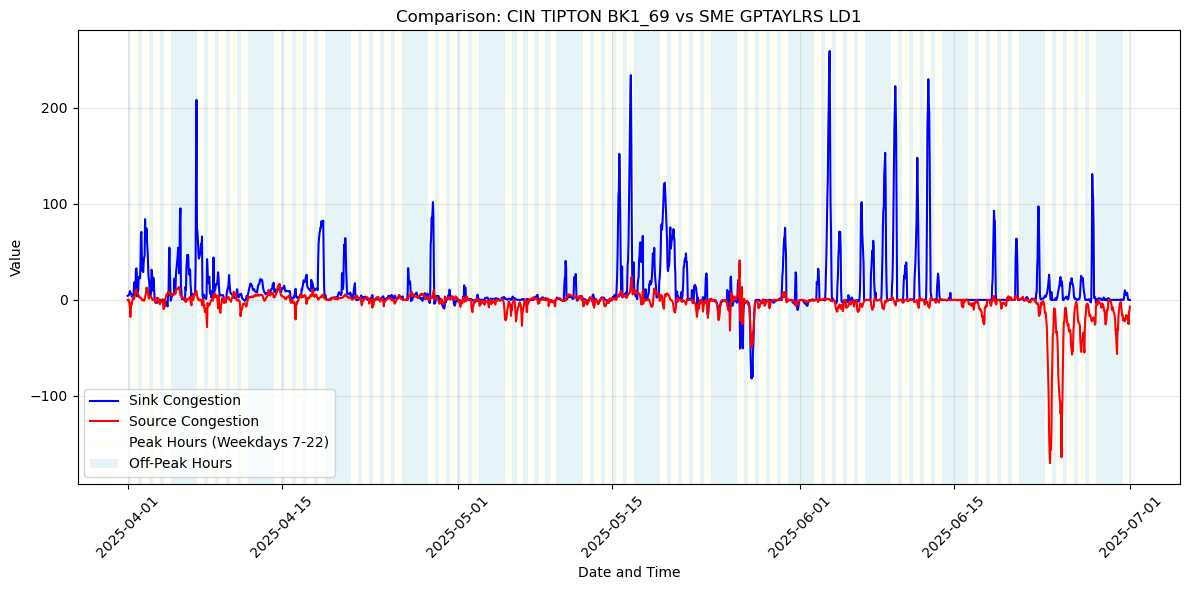

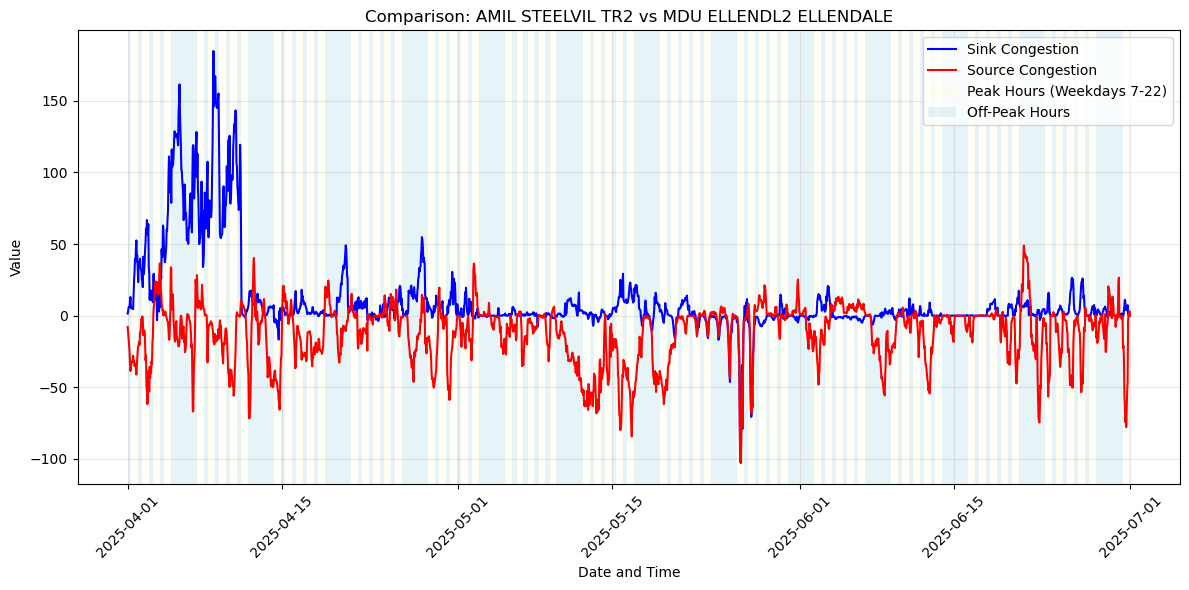

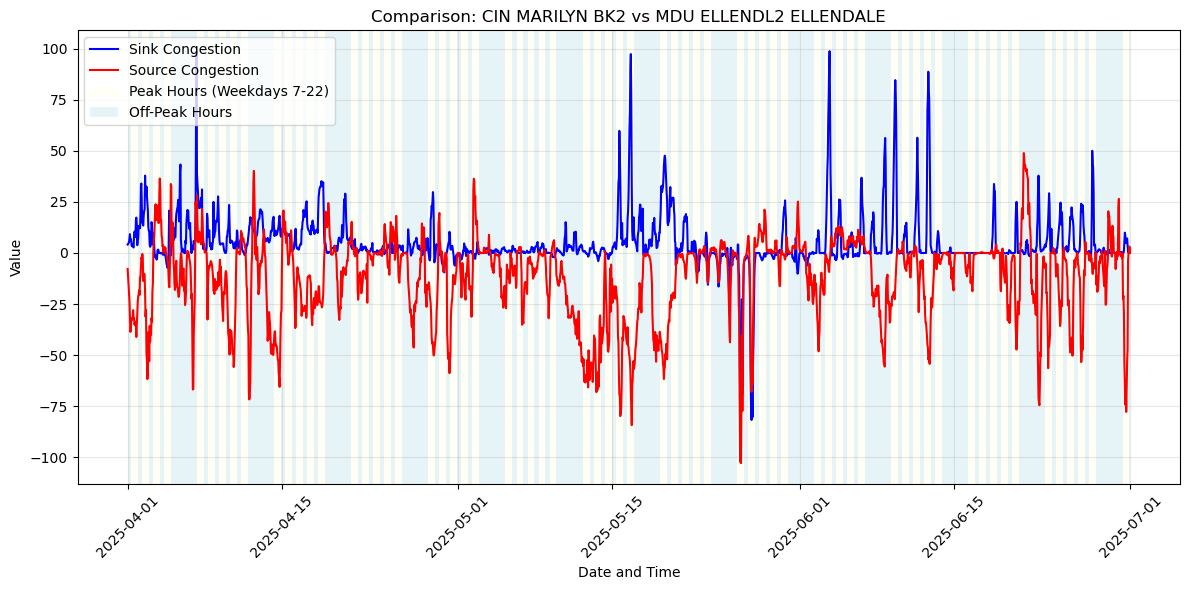

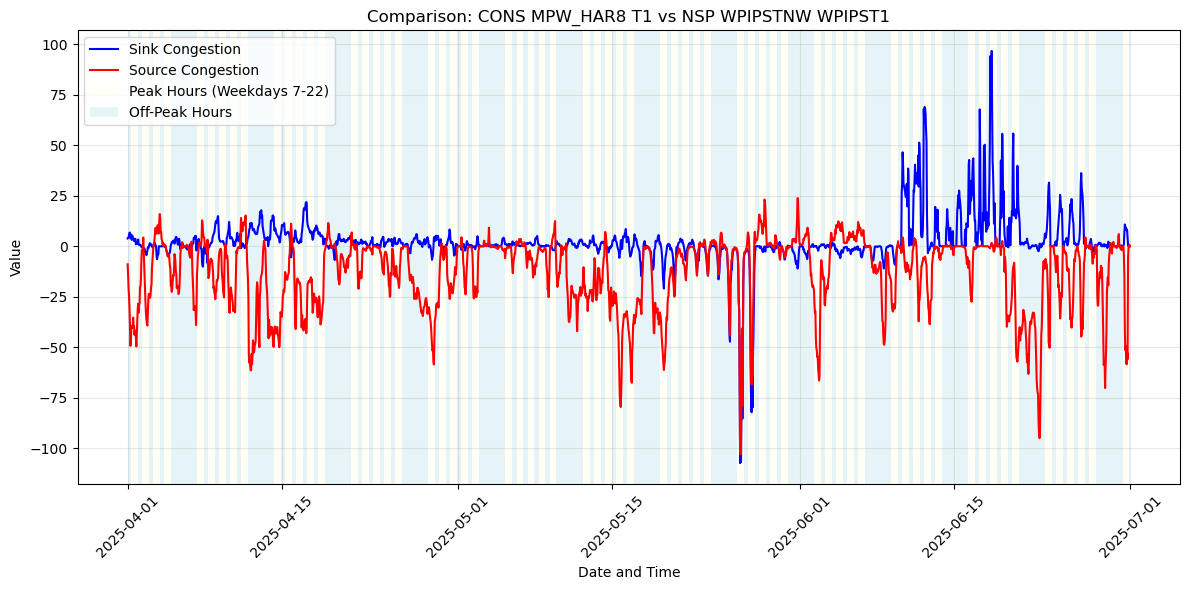

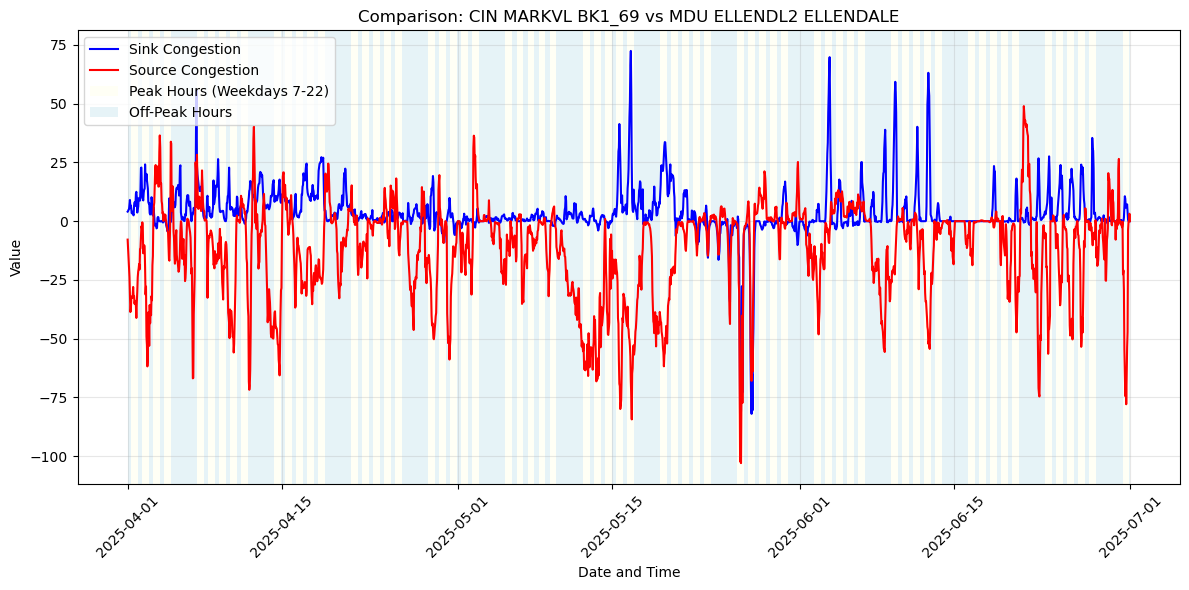

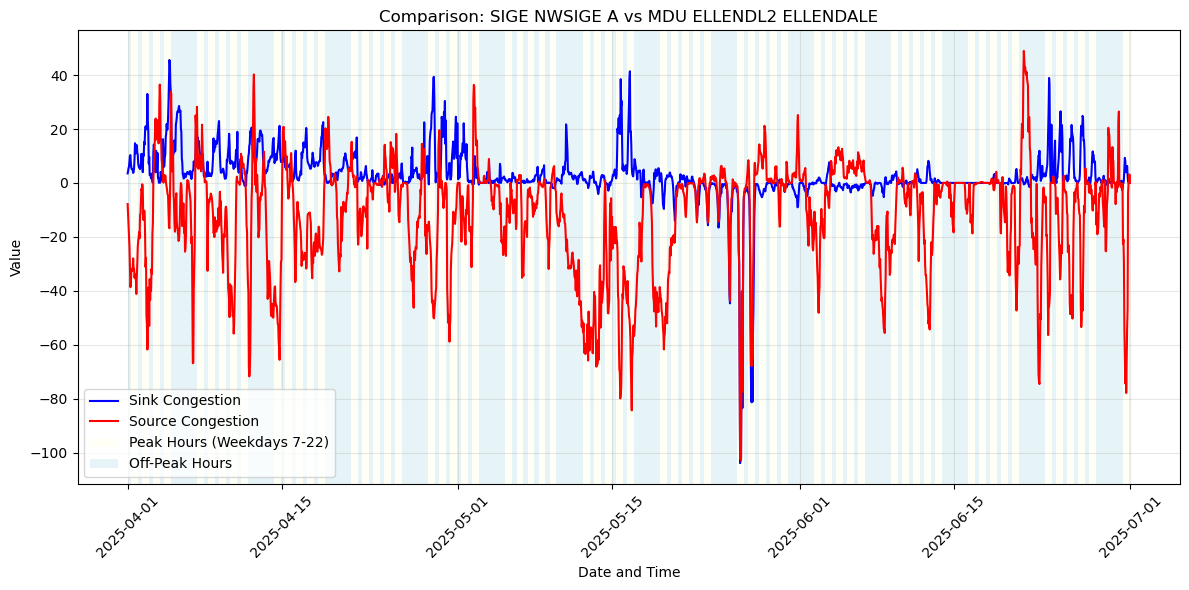

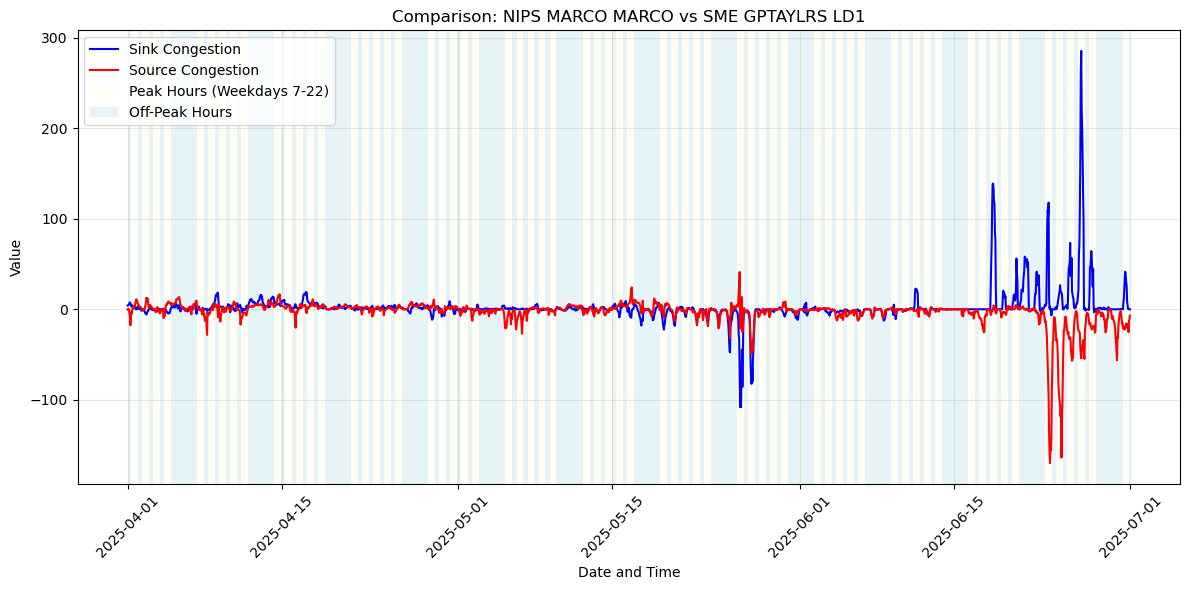

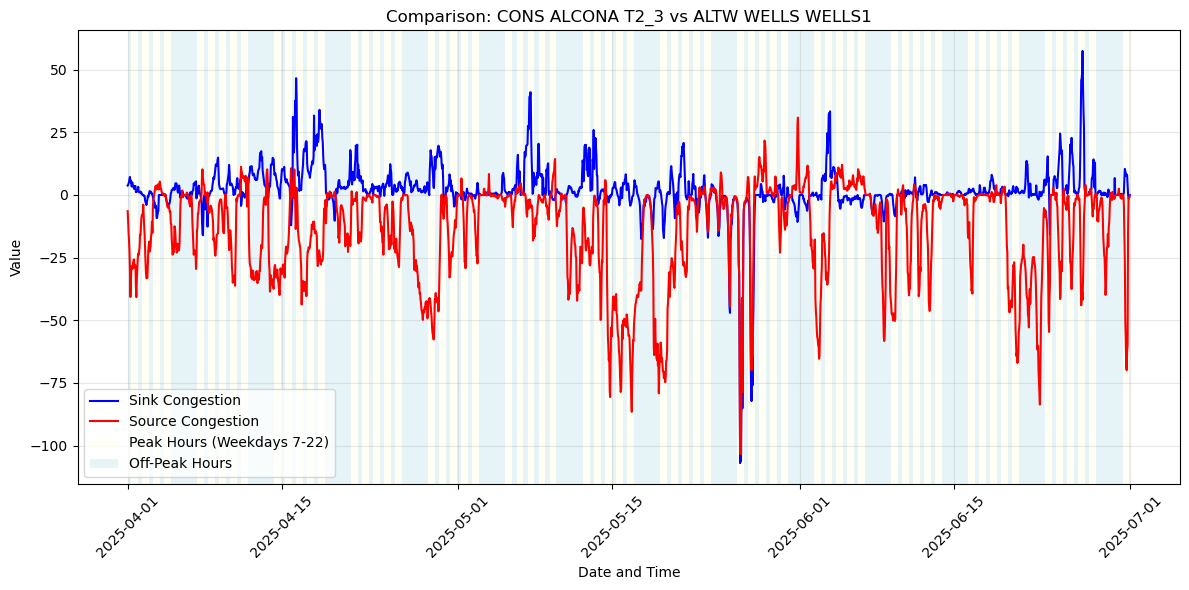

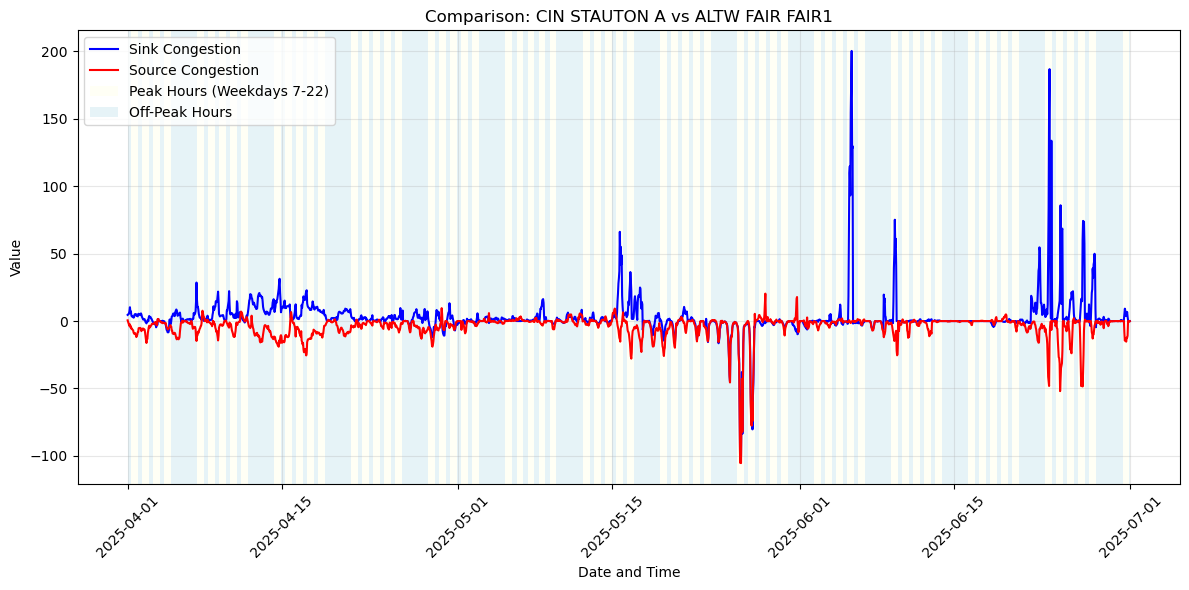

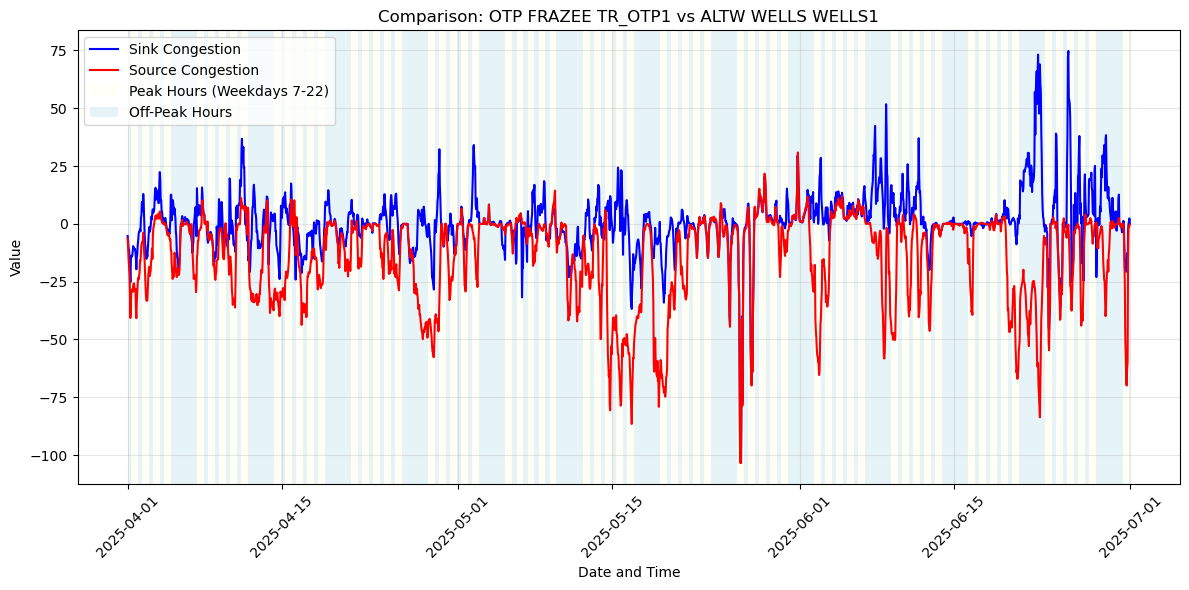

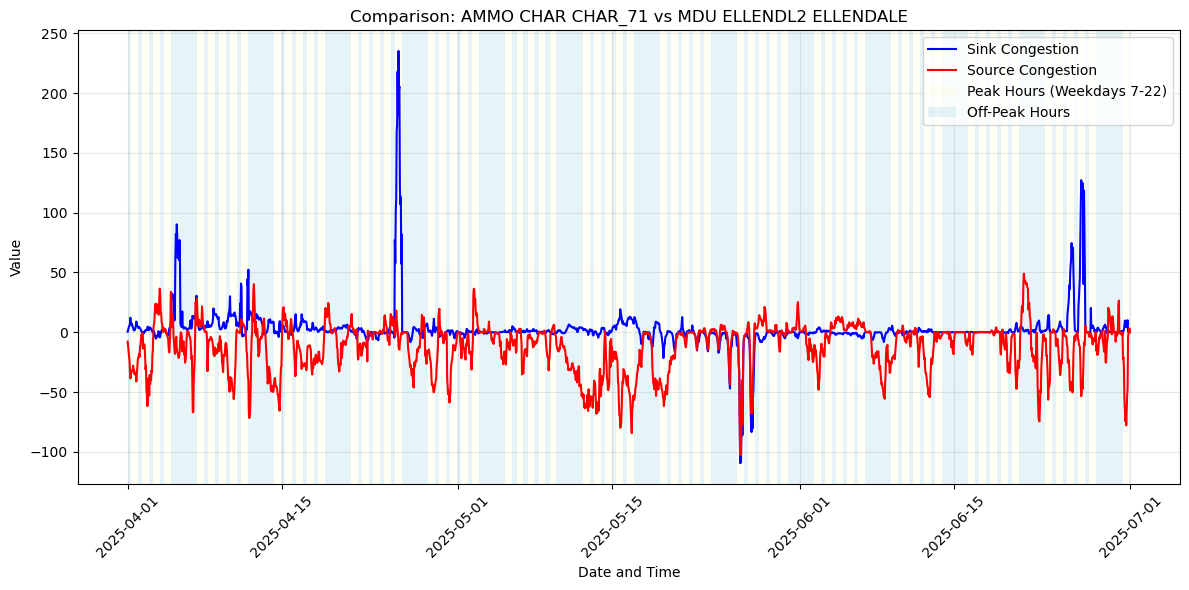

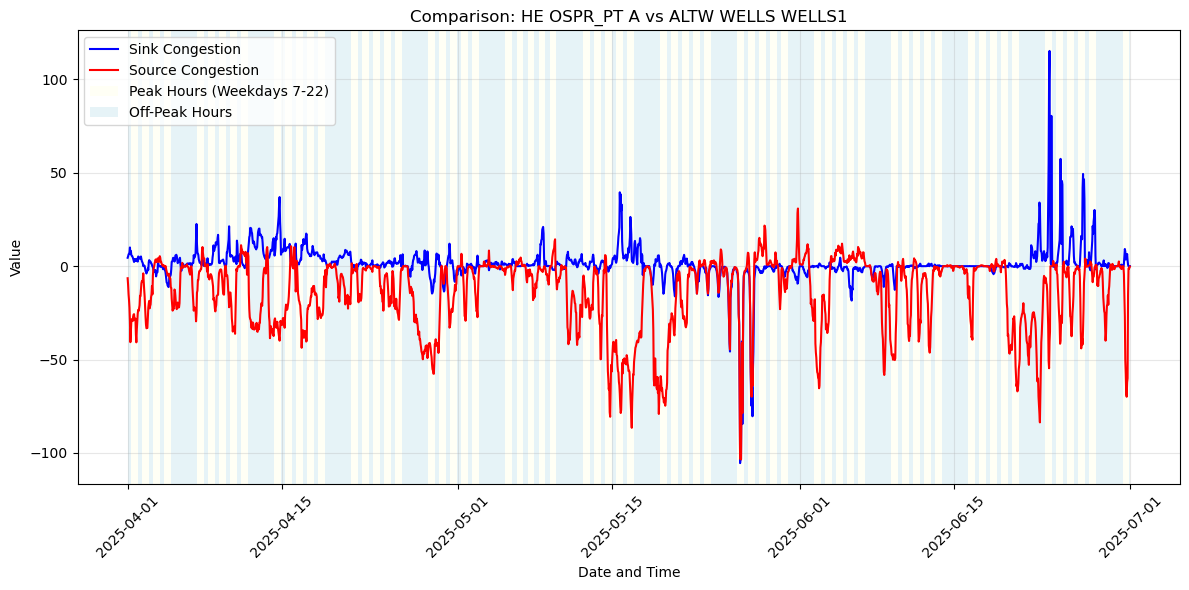

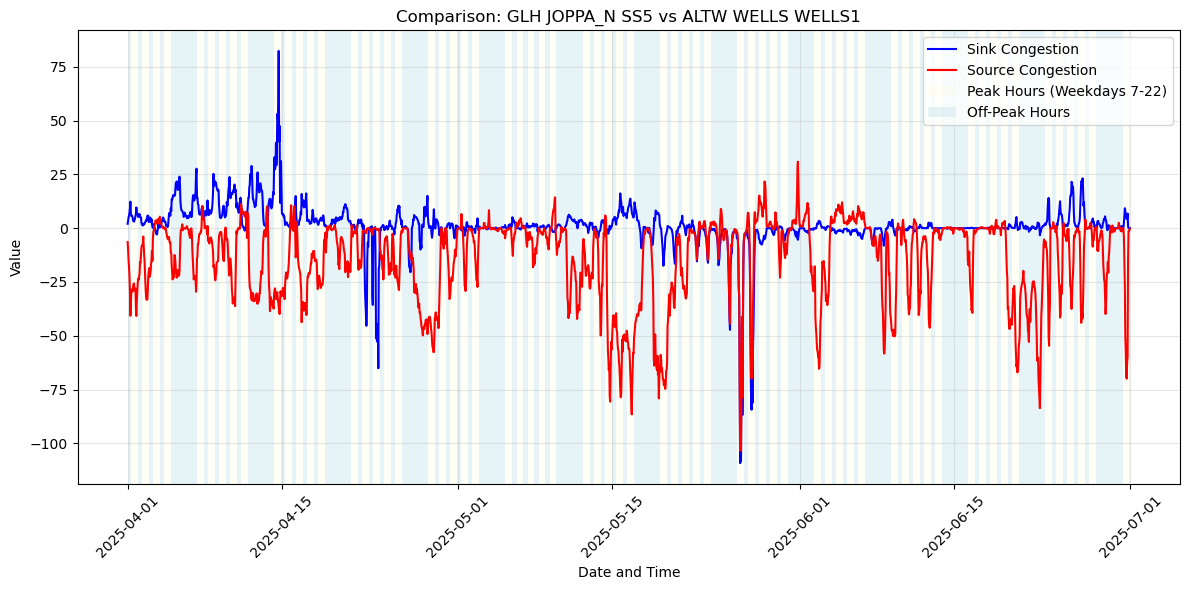

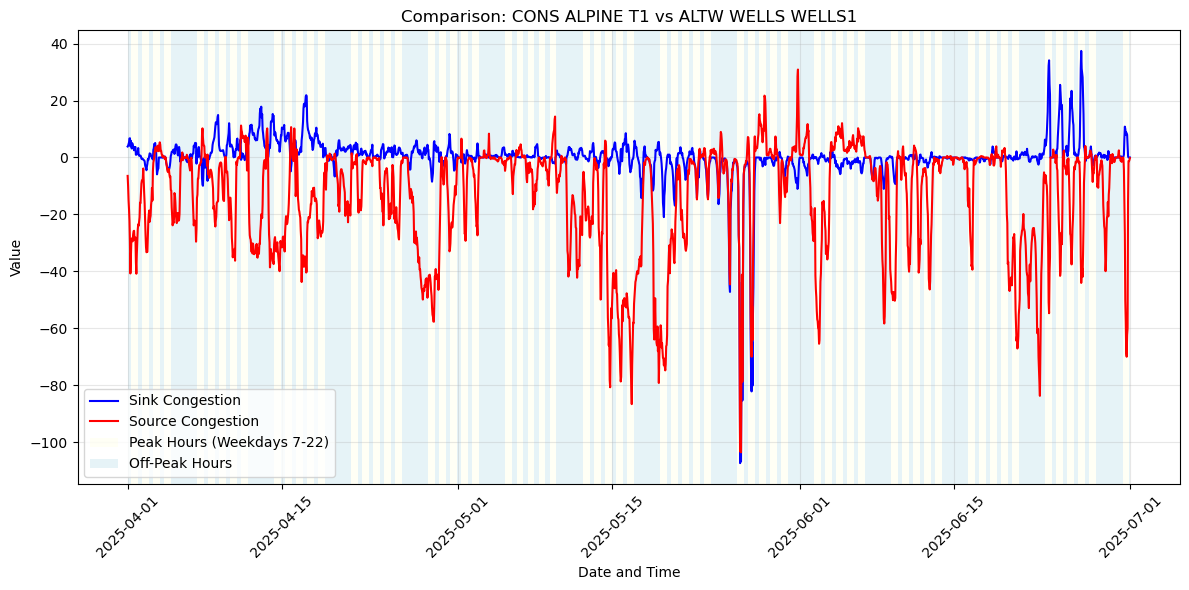

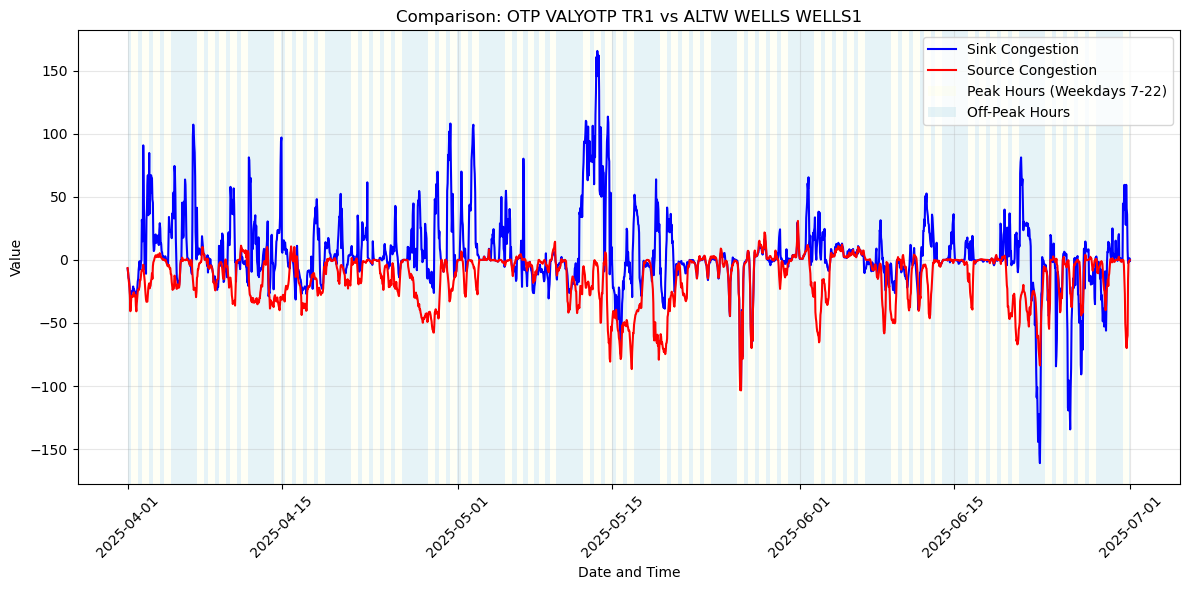

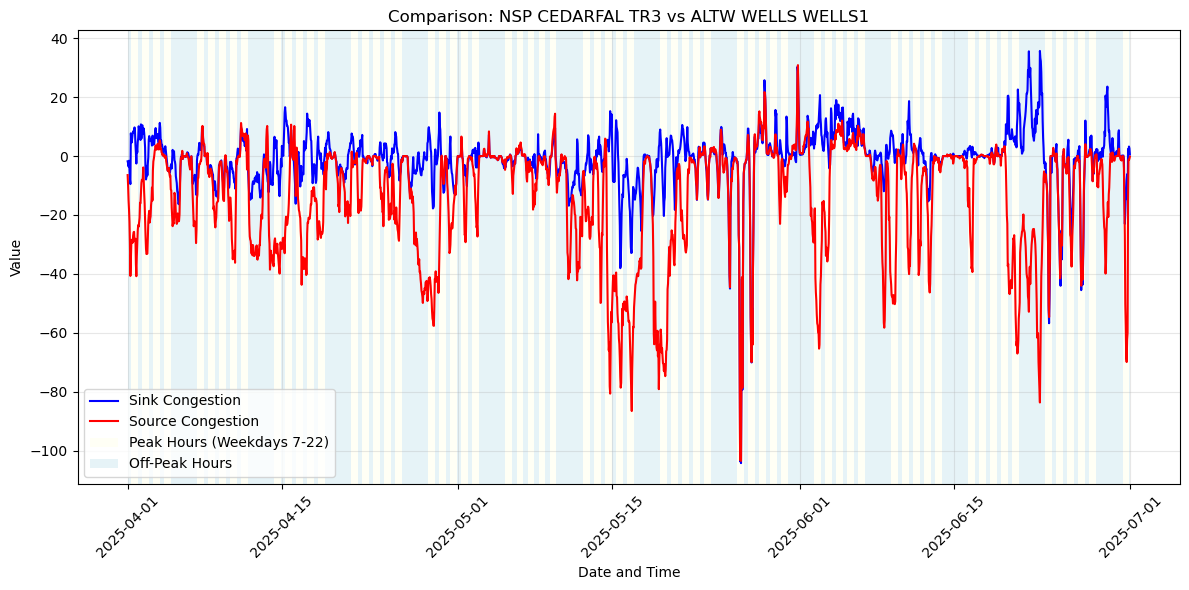

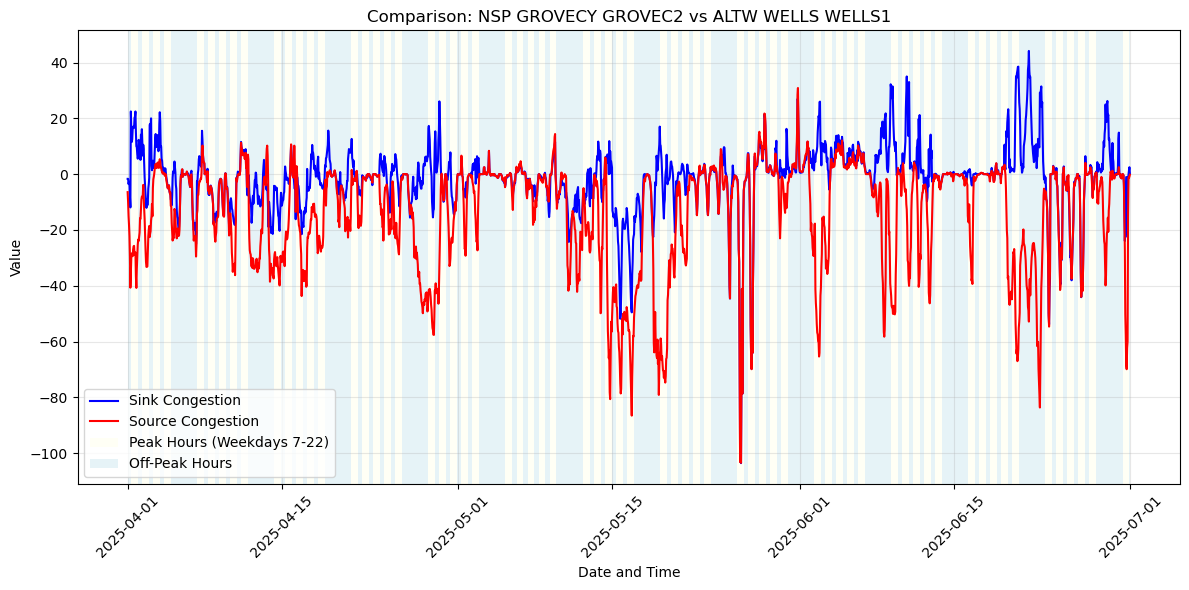

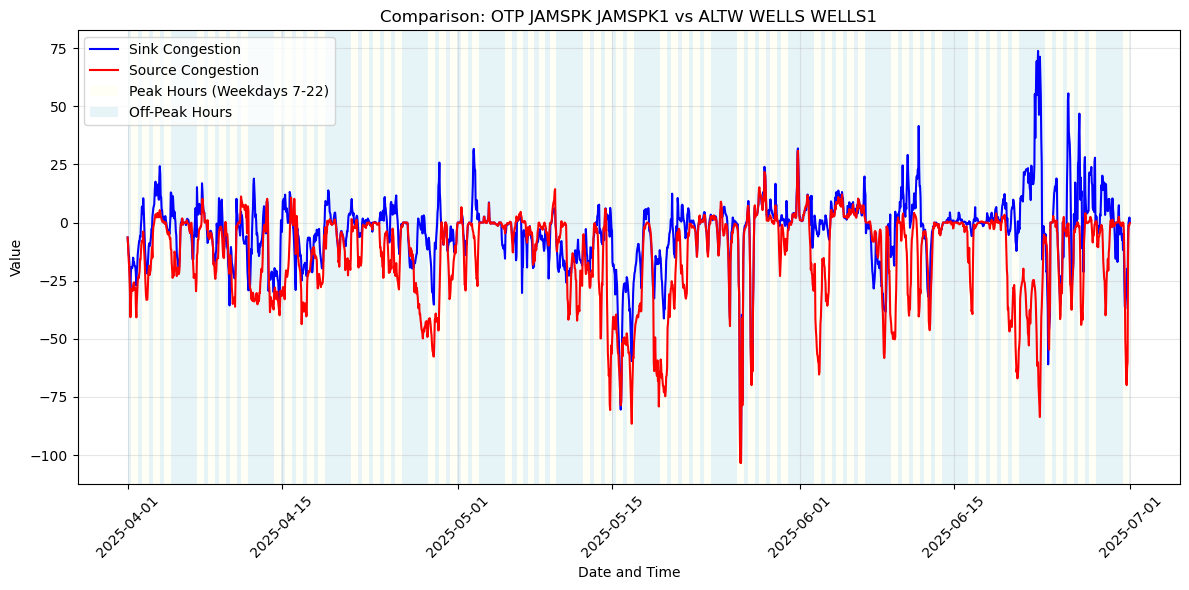

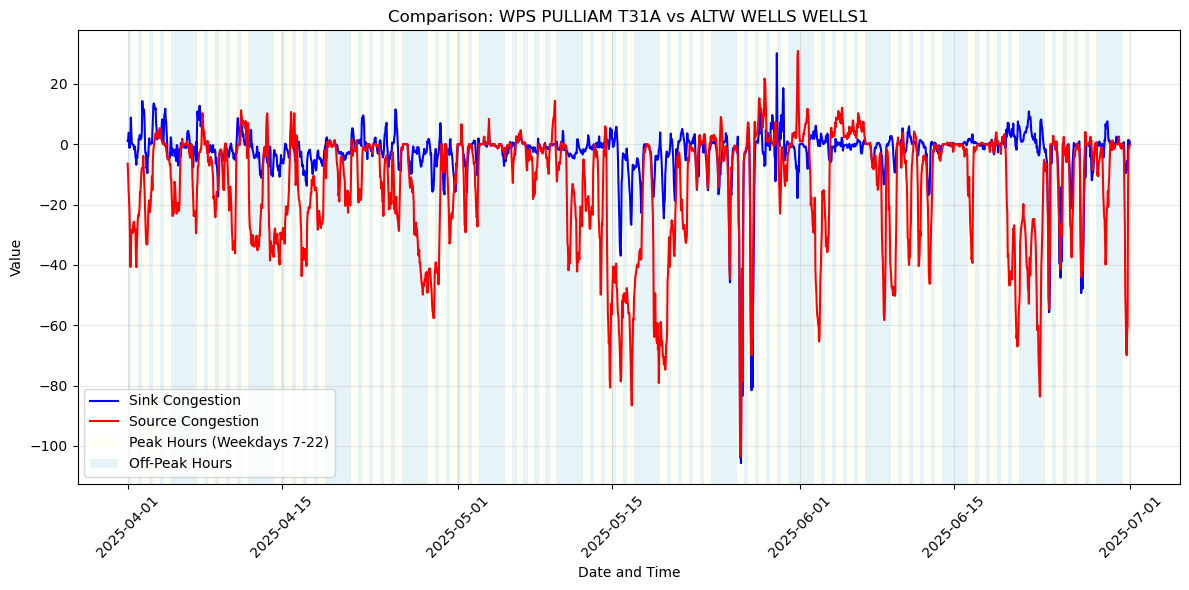

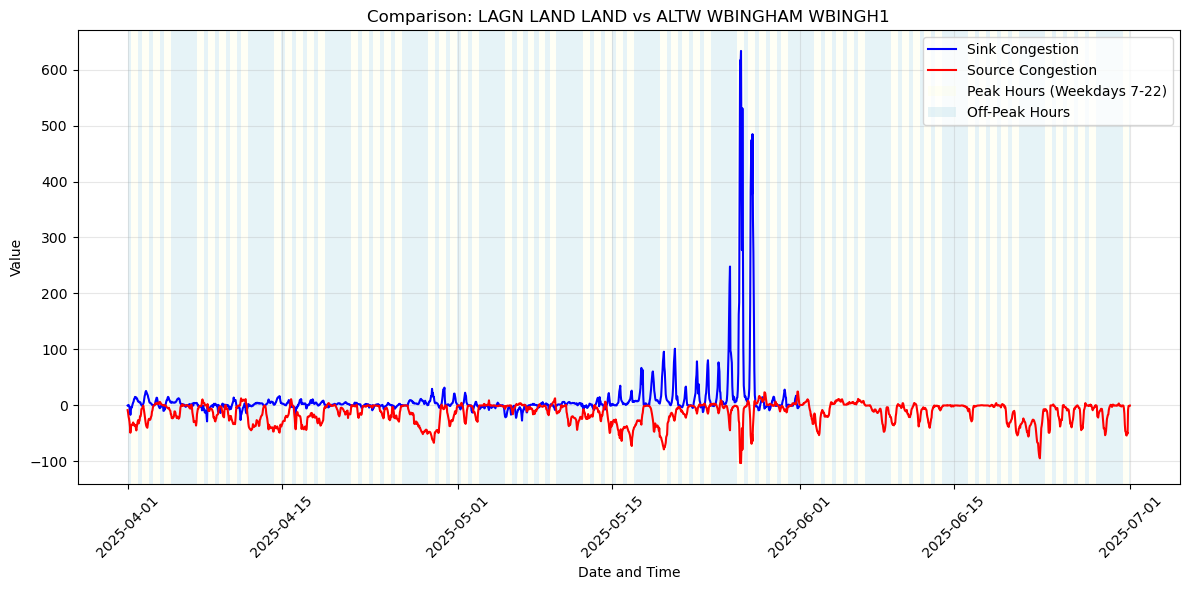

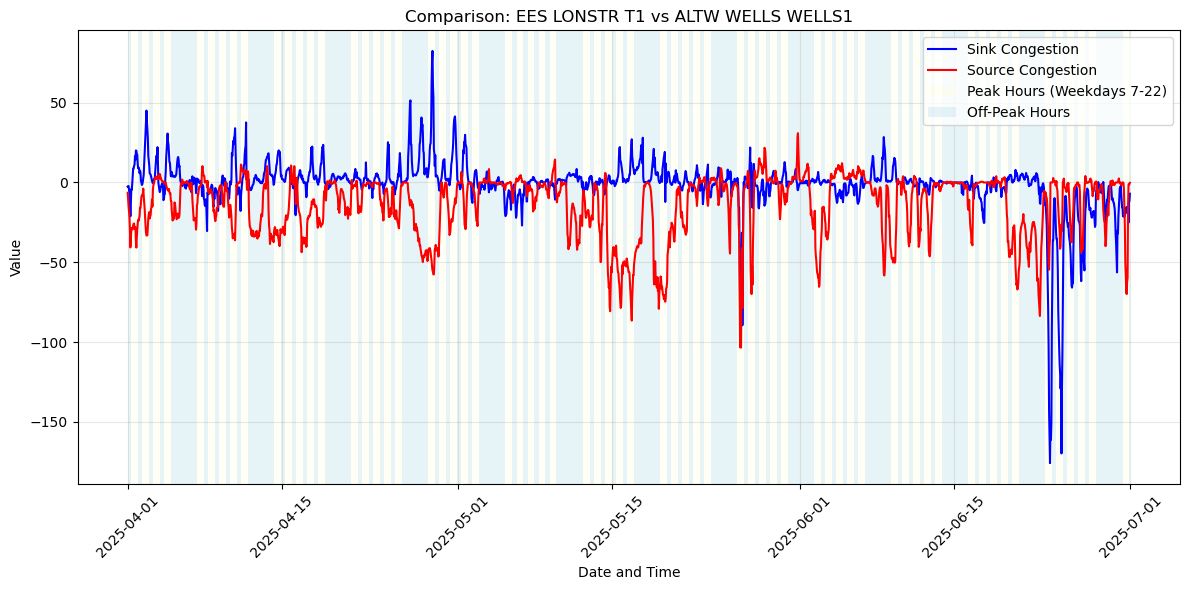

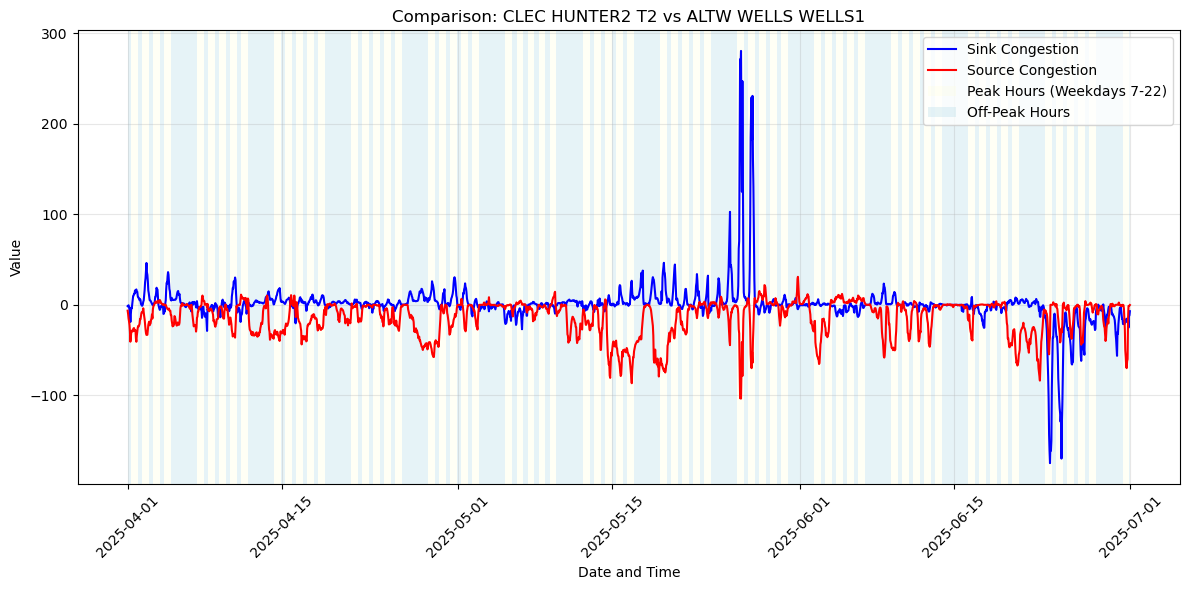

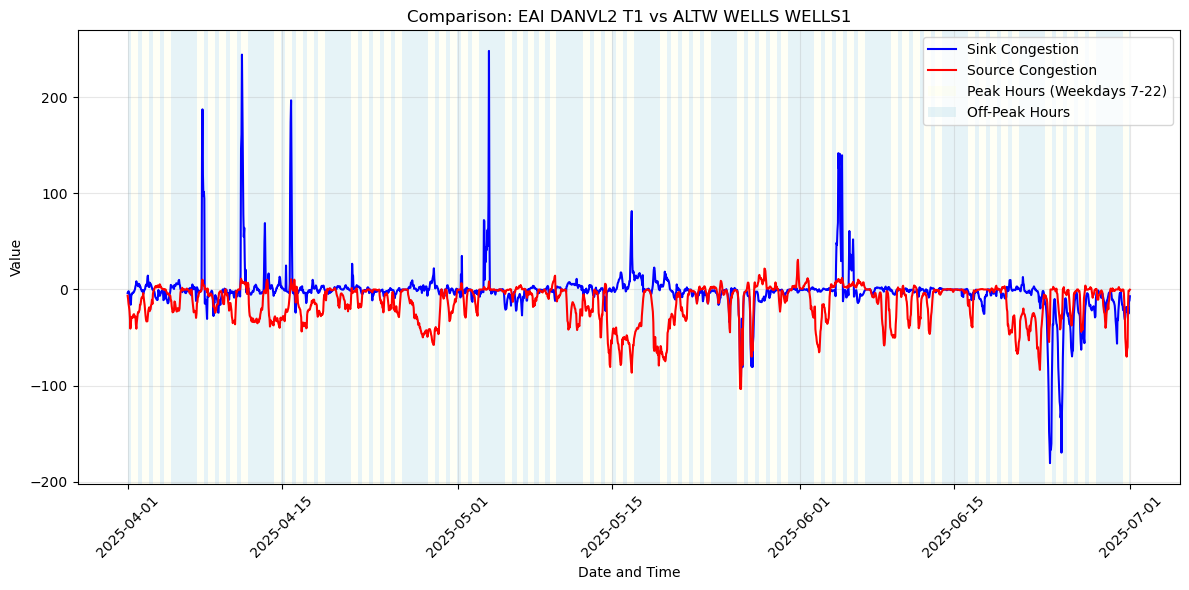

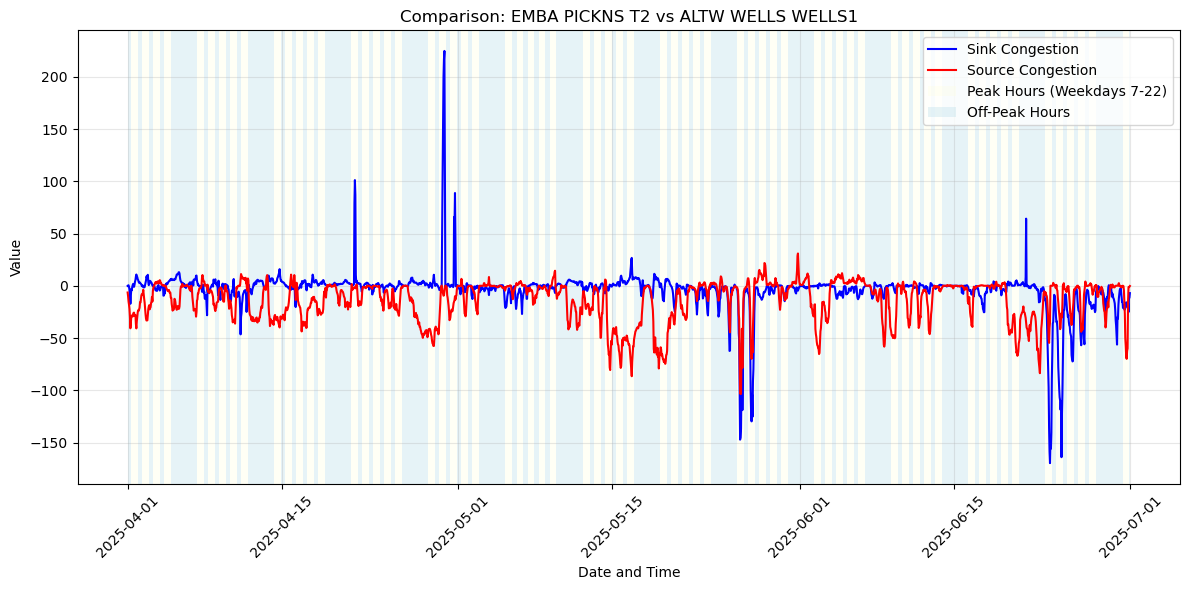

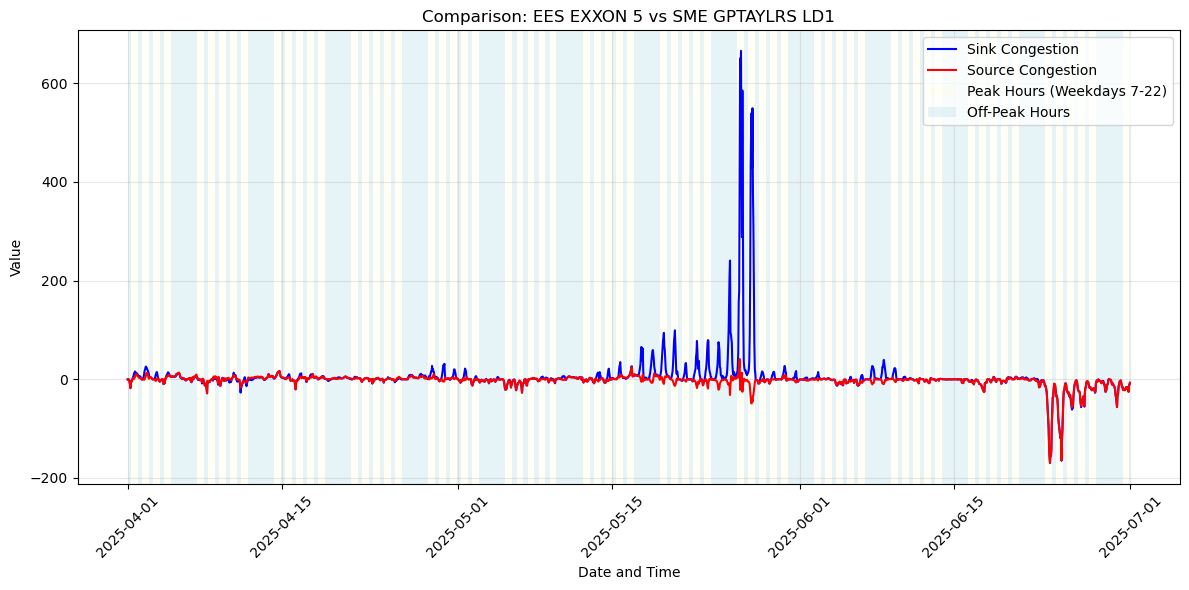

In [63]:
# Open a multi-page PDF
with PdfPages('Outputs/onPeak_LMP_timeseries.pdf') as pdf:
    for i in range(len(best_sink_source_spreads)):
        # Determine best cluster and node
        cluster = onPeakCombined.loc[onPeakCombined['node'] == best_sink_source_spreads.loc[i, 'source'], 'cluster'].item()
        
        node = top_source_matches.loc[top_source_matches['cluster'] == cluster, 'node'].item()
        
        # Update source in best spread list
        best_sink_source_spreads.loc[i, 'source'] = node

        # Get DA LMP data
        DA_LMP_train_InterestNodeSource = DA_LMP_train.loc[DA_LMP_train['node'] == node]
        DA_LMP_train_InterestNodeSink = DA_LMP_train.loc[DA_LMP_train['node'] == best_sink_source_spreads.loc[i, 'sink']]

        # Plot using your function and save the figure
        fig, ax = plot_dual_timeseries(
            DA_LMP_train_InterestNodeSink,
            DA_LMP_train_InterestNodeSource,
            y_column1='congestion',
            label1='Sink Congestion',
            label2='Source Congestion'
        )
        
        pdf.savefig(fig)
        plt.close(fig)  # Close to avoid displaying or memory issues

In [64]:
strategy_results = pd.DataFrame(columns = ['Analysis Start Date', 'Analysis End Date', 'Mean Congestion Spread', 'Congestion Spread Standard Dev', 'LMP Sink', 'Closest matching FTR Sink', 'LMP Source', 'Closest matching FTR Source'])

## On Peak strategy results ##
for i in range(0, len(best_sink_source_spreads)): 
    # on peak sink node assignment
    on_peak_DA_LMP_train_InterestNodeSink = on_peak_DA_LMP_train.loc[on_peak_DA_LMP_train['node'] == best_sink_source_spreads.loc[i, 'sink'], :]
    on_peak_DA_LMP_train_InterestNodeSink = on_peak_DA_LMP_train_InterestNodeSink.set_index(pd.to_datetime(on_peak_DA_LMP_train_InterestNodeSink['datetime']))
    
    #source node assignment
    on_peak_DA_LMP_train_InterestNodeSource = on_peak_DA_LMP_train.loc[on_peak_DA_LMP_train['node'] == best_sink_source_spreads.loc[i, 'source'], :]
    on_peak_DA_LMP_train_InterestNodeSource = on_peak_DA_LMP_train_InterestNodeSource.set_index(pd.to_datetime(on_peak_DA_LMP_train_InterestNodeSource['datetime']))
    
    #analyze on peak difference for on peak strategy
    CongestionSpread_TimeSeries = on_peak_DA_LMP_train_InterestNodeSink.loc[:, 'congestion'] - on_peak_DA_LMP_train_InterestNodeSource.loc[:, 'congestion']

    # Creating a dataframe that holds strategy relevant information
    strategy_results.loc[i, 'Analysis Start Date'] = CongestionSpread_TimeSeries.index.min()
    strategy_results.loc[i, 'Analysis End Date'] = CongestionSpread_TimeSeries.index.max()
    strategy_results.loc[i, 'Mean Congestion Spread'] = round(CongestionSpread_TimeSeries.mean(), 2)
    strategy_results.loc[i, 'Congestion Spread Standard Dev'] = round(CongestionSpread_TimeSeries.std(), 2)
    strategy_results.loc[i, 'LMP Sink'] = best_sink_source_spreads.loc[i, 'sink']
    strategy_results.loc[i, 'Closest matching FTR Sink'] = onPeakCombined.loc[onPeakCombined['node'] == best_sink_source_spreads.loc[i, 'sink'], 'matched_source_sink'].item()
    strategy_results.loc[i, 'LMP Source'] = best_sink_source_spreads.loc[i, 'source']
    strategy_results.loc[i, 'Closest matching FTR Source'] = onPeakCombined.loc[onPeakCombined['node'] == best_sink_source_spreads.loc[i, 'source'], 'matched_source_sink'].item()
    
    # Creating a readout for the program
    print(f"ON PEAK STRATEGY for sink {best_sink_source_spreads.loc[i, 'sink']} and source {best_sink_source_spreads.loc[i, 'source']}:")
    print(f"Congestion spread expected value: ${round(CongestionSpread_TimeSeries.mean(), 2)}")
    print(f"Congestion spread standard deviation: ${round(CongestionSpread_TimeSeries.std(), 2)}")
    MW_Bid = 1
    Hourly_profit = CongestionSpread_TimeSeries.mean() * MW_Bid
    Monthly_profit = Hourly_profit * 720
    print(f"Monthly value of 1 MW: ${round(Monthly_profit, 2)}")
    print('---------------------------')

strategy_results.to_csv('Outputs/OnPeakStrategyResults.csv')


ON PEAK STRATEGY for sink CIN TIPTON BK1_69 and source SME GPTAYLRS LD1:
Congestion spread expected value: $23.1
Congestion spread standard deviation: $41.34
Monthly value of 1 MW: $16632.49
---------------------------
ON PEAK STRATEGY for sink AMIL STEELVIL TR2 and source MDU ELLENDL2 ELLENDALE:
Congestion spread expected value: $23.05
Congestion spread standard deviation: $34.04
Monthly value of 1 MW: $16596.39
---------------------------
ON PEAK STRATEGY for sink CIN MARILYN BK2 and source MDU ELLENDL2 ELLENDALE:
Congestion spread expected value: $20.98
Congestion spread standard deviation: $29.28
Monthly value of 1 MW: $15104.15
---------------------------
ON PEAK STRATEGY for sink CONS MPW_HAR8 T1 and source NSP WPIPSTNW WPIPST1:
Congestion spread expected value: $16.65
Congestion spread standard deviation: $22.16
Monthly value of 1 MW: $11986.91
---------------------------
ON PEAK STRATEGY for sink CIN MARKVL BK1_69 and source MDU ELLENDL2 ELLENDALE:
Congestion spread expected va

In [65]:
###### START OFF PEAK STRATEGY ##########
# Grabbing the top unique clusters
top_unique_rows = offPeakCombined.drop_duplicates(subset=['cluster'], keep='first')

# If you want to keep only specific number of rows (e.g., top 5) after removing duplicates
n_clusters_to_analyze = 25
top_n_unique_rows = top_unique_rows.head(n_clusters_to_analyze)

#filter to all of the nodes that belong to the best performing clusters
Best_sink_clusters = offPeakCombined[offPeakCombined['cluster'].isin(top_n_unique_rows['cluster'].values)]

#select node in the best cluster with the best match score
idx = Best_sink_clusters.groupby('cluster')['match_score'].idxmax()
Best_sink_clusters = Best_sink_clusters.loc[idx]

#pull all of the lmp data for those best nodes
DA_LMP_train_InterestNodeSink = DA_LMP_train[DA_LMP_train['node'].isin(Best_sink_clusters['node'])]

# Set index to datetime and convert to datetime in one step
DA_LMP_train_InterestNodeSink = DA_LMP_train_InterestNodeSink.set_index(pd.to_datetime(DA_LMP_train_InterestNodeSink['datetime']))

#Display the highest scored sink node options
print('Best off-peak sink options that belong to different clusters and have high FTR matchability:')
Best_sink_clusters

Best off-peak sink options that belong to different clusters and have high FTR matchability:


node matched_source_sink  match_score  \
2          CLEC HUNTER2 T2        CLEC.HUNTER5           81   
1917     AMIL STEELVIL TR2         AMIL.TILTU2           71   
4046     AMIL EDWARDS2 TR7       AMIL.EDWARDS2           87   
13821         HE OSPR_PT A          HE.OSPR_PT           91   
10776   AMMO CALLAWAY AUX1      AMMO.CALLAWAY1           81   
6841       OTP VALYOTP TR1             OTP.OTP           64   
10471     CONS ALCONA T2_3         CONS.ALCONA           81   
14583    ALTE ALBANY00 XF2         ALTE.ALBANY           79   
11622   OTP FRAZEE TR_OTP1       OTP.OTPW_1.AZ           71   
6670       OTP LAKTOTP TR1       OTP.OTPW_1.AZ           64   
13151  NSP PR_ISLD PR_ISL2       NSP.PRISL2_LD           81   
5882   NSP BURNVIL GRE_TR1      NSP.BR_DIR_TR1           73   
9308       BREC SKILLMAN B       BREC.SKILLMAN           93   
8265        CONS ALPINE T1       CONS.ALPINE02           81   
2237       OTP MN_PIPE TR2        OTP.MPC.YNG2           59   
11895      CIN MARILYN BK1       CIN.MARKLND.1           79   
12177        EES LONSTR T1         EES.LONSTR1           92   
1221          NSP SPG SPG1         NSP.SPGSPG1           96   
6187       AMMO OSAGE O_88       AMMO.CC.OSAGE           79   
12403      GLH JOPPA_N SS6          GLH.JOPPA6           80   
1253           EES EXXON 5           EES.EXXON           90   
449       NSP DAHLGREN TR1       GRE.NSPP_1.AZ           62   
14129     NSP CEDARFAL TR3        NSP.CEDARFAL           86   
8779     NSP GROVE2 GROVE1        GRE.NSP.GREC           76   
9040    CWLP DALLMAN LDGS3       CWLP.DALLMA83           77   

       congestion deviation  congestion mean  congestion skew  \
2                  9.202810         0.673408         1.469126   
1917              28.551376        11.472126         3.169732   
4046               4.675658        -1.937709        -2.165411   
13821              5.247646         1.761497        -0.138177   
10776              5.515960         1.211398         0.340555   
6841              26.547536         5.532539        -0.112470   
10471              6.029288         1.957701         0.117403   
14583             21.095564         2.237552         5.086398   
11622             11.525712         1.565864         1.784982   
6670              19.866998         1.667080         2.863371   
13151              8.693196        -0.443309         0.785431   
5882              14.992218         2.802514         3.133069   
9308               5.180185         2.097229        -0.340850   
8265               4.579685         0.902514        -1.624502   
2237              11.752348         2.820149         1.340576   
11895              7.949410         3.695186         3.453325   
12177              8.280972         0.040347        -0.494866   
1221              10.002620         0.800910         1.935319   
6187               9.776040         3.685674         2.154823   
12403              6.360132         2.091150        -0.087250   
1253              15.346029         2.046294         7.016756   
449               78.338992        19.983648         4.461218   
14129              7.251791        -0.299628         0.472077   
8779               8.747314        -0.514251         0.761164   
9040               5.989091        -2.094045        -2.155051   

       congestion kurtosis  Sink score  Source score  cluster  
2                26.698101   38.153718     60.551096        6  
1917             10.012792   69.161886     39.309094        8  
4046             15.105690   28.312015     69.208704       13  
13821            14.000745   38.723748     61.437968       14  
10776            12.758375   38.224298     62.474279       16  
6841              7.306961   52.488244     52.601028       20  
10471            11.179942   39.825980     61.295607       21  
14583            34.206652   47.799560     53.637942       25  
11622             7.835786   42.389750     61.272099       28  
6670             10.977966   45.565311     59.197799

In [66]:
### This block is calculating metrics for each sink/source node pair our chosen sink nodes ###
# Create an empty DataFrame to store all results
all_source_results = pd.DataFrame()

for node in Best_sink_clusters['node'].values:
    # Pivot the data to get congestion values per node in columns
    pivot_df = off_peak_DA_LMP_train.pivot(index='datetime', columns='node', values='congestion')
    
    # Identify the sink node of interest
    sink_series = pivot_df[node]
    
    # Compute spread: subtract every column from sink node
    spread_df = sink_series.values.reshape(-1, 1) - pivot_df

    # Compute metrics across time for each source node
    source_results = pd.DataFrame({
        'sink': node,
        'source': spread_df.columns,
        'mean_congestion': spread_df.mean(),
        'std_dev': spread_df.std(),
        'kurt': spread_df.kurt(),
        'pct_positive': (spread_df > 0).sum() / len(spread_df)
    })

    # Concatenate the results to the main DataFrame
    all_source_results = pd.concat([all_source_results, source_results], ignore_index=True)

In [67]:
### This block is scoring spreads to find the best source to match our sink based on spread metrics
#scale mean and standard deviation to compare on similar scales
scaler = StandardScaler()
scaled_metrics = scaler.fit_transform(all_source_results[['mean_congestion', 'std_dev', 'kurt', 'pct_positive']])
all_source_results[['scaled_mean', 'scaled_std', 'scaled_kurt', 'scaled_pct_positive']] = scaled_metrics

# weight for mean_congestion (positive spread is good) negative weight for std_dev (we prefer lower volatility)
w_mean = 5   
w_std = -2
w_kurt = -3
w_pos = 4

# Compute weighted score on scaled values for a sink/source spread score
all_source_results['Spread_score'] = w_mean * all_source_results['scaled_mean'] + w_std * all_source_results['scaled_std'] + w_kurt * all_source_results['scaled_kurt'] + w_pos * all_source_results['pct_positive']

# Drop the scaled mean, std, kurt, and pct pos columns
all_source_results = all_source_results.drop(columns = ['scaled_mean', 'scaled_std', 'scaled_kurt', 'scaled_pct_positive'])

# Initialize scaler to cast to 0-100 range
scaler = MinMaxScaler(feature_range=(0, 100))

# Scale spread score
all_source_results['Spread_score'] = scaler.fit_transform(all_source_results[['Spread_score']])

# Sort by sink and descending Spread_score
sorted_spreads = all_source_results.sort_values(['Spread_score'], ascending=False)

assigned_sources = set()
unique_sink_source_pairs = []

for _, row in sorted_spreads.iterrows():
    sink = row['sink']
    source = row['source']
    
    # Skip if source already assigned
    if source in assigned_sources:
        continue
    
    # Skip if sink already has a pair assigned
    if any(pair['sink'] == sink for pair in unique_sink_source_pairs):
        continue
    
    assigned_sources.add(source)
    unique_sink_source_pairs.append(row)

# Convert list of rows to DataFrame
best_sink_source_spreads = pd.DataFrame(unique_sink_source_pairs).reset_index(drop = True)

print('Optimal unique source for each sink (no duplicate sources):')
best_sink_source_spreads


Optimal unique source for each sink (no duplicate sources):


sink                 source  mean_congestion     std_dev  \
0      NSP DAHLGREN TR1    NSP SLAYTON GRE_TR1        72.247259  147.246770   
1     AMIL STEELVIL TR2    OTP HOVINGJ HOVING2        29.451836   43.649902   
2       OTP LAKTOTP TR1    DPC CENTLDS CENTLD1        23.282593   31.268803   
3       OTP MN_PIPE TR2     OTP LISBON LISBON1        20.799859   30.383305   
4       CIN MARILYN BK1    OTP GWINNER GWINNE2        21.674897   33.539353   
5       AMMO OSAGE O_88    OTP GWINNER GWINNE1        21.665385   34.892638   
6       OTP VALYOTP TR1        NSP MARS_SW TR1        20.957750   34.874581   
7       BREC SKILLMAN B    NSP SLAYTON SLAYTO1        16.911588   24.208914   
8      CONS ALCONA T2_3       MEC NEALN NEALN2        15.893921   20.602603   
9       GLH JOPPA_N SS6    MEC NEALN NEALN_THS        16.027370   21.429951   
10   OTP FRAZEE TR_OTP1  ALTW WINBCITY GRE_TR1        18.923630   27.013145   
11         HE OSPR_PT A     NSP CURRIE CURRIE1        16.553615   25.026964   
12    ALTE ALBANY00 XF2   NSP LAKSARAH LAKSAR1        17.023259   26.450197   
13  NSP BURNVIL GRE_TR1   ALTW NORWOOD NORWOO1        16.568908   27.459933   
14       CONS ALPINE T1       MEC NEALN NEALN1        14.838734   20.110611   
15   AMMO CALLAWAY AUX1    MEC LBRTYMEC SLB8T1        15.139264   21.606889   
16          EES EXXON 5    NSP TRACYSW TRACYS1        16.836989   28.624940   
17      CLEC HUNTER2 T2        NSP TRACYSW TRA        15.464103   25.942505   
18         NSP SPG SPG1  ALTW GLENVILL GLENVI1        14.556658   23.030870   
19        EES LONSTR T1    NSP LKYNKTN LKYNKT1        14.575591   25.345680   
20     NSP CEDARFAL TR3    DPC RICELAN RICELA2        13.456121   20.794217   
21  NSP PR_ISLD PR_ISL2   ALTW HAYWARD HAYWAR1        13.312440   21.439968   
22    NSP GROVE2 GROVE1    DPC RICELAN RICELA1        13.241497   21.062324   
23    AMIL EDWARDS2 TR7    MEC LBRTYMEC SLB8T2        11.990157   18.126532   
24   CWLP DALLMAN LDGS3       MEC NEALS NEALS2        11.727419   18.613066   

         kurt  pct_positive  Spread_score  
0    4.983854      0.267163    100.000000  
1    3.087973      0.727047     86.607596  
2    0.240844      0.271299     83.421247  
3    2.466787      0.823821     83.316355  
4    1.948165      0.711332     83.303008  
5    2.849620      0.674938     83.052239  
6    3.509407      0.699752     82.694954  
7    4.116773      0.766749     81.504568  
8    1.892482      0.783292     81.421006  
9    1.723849      0.765922     81.396530  
10   5.299384      0.291977     81.181753  
11   4.620815      0.732837     81.140522  
12   8.861443      0.729529     81.014075  
13   6.697983      0.746071     80.861579  
14   2.180541      0.741935     80.785493  
15   3.380758      0.716294     80.695187  
16  11.560553      0.710505     80.536056  
17   2.918649      0.696443     80.507174  
18   4.710186      0.750207     80.271058  
19   2.083854      0.676592     80.086215  
20   3.894958      0.763441     79.942411  
21   4.371325      0.745244     79.744034  
22   4.575553      0.729529     79.687414  
23   3.532328      0.685691     79.215379  
24   2.947833      0.670802     79.037990

In [68]:
### Select all nodes that are in the same clusters as selected sources then find the node with highest match score for each cluster ###
# extract the best source cluster for that sink  
source_clusters = offPeakCombined.loc[offPeakCombined['node'].isin(best_sink_source_spreads['source']), 'cluster'].values

#filter down to the source cluster
top_source_matches = (offPeakCombined[offPeakCombined['cluster'].isin(source_clusters)]
                      .sort_values(['cluster', 'match_score'], ascending=[True, False])
                      .groupby('cluster')
                      .first()  # Take the first row of each group (highest match_score)
                      .reset_index())  # Convert the index back to a column

#best source LMP's after filtering for matchability
print('Best source LMPs after considering FTR matchability:')
top_source_matches

Best source LMPs after considering FTR matchability:


cluster                 node matched_source_sink  match_score  \
0        7     MEC NEALN NEALN3         MEC.NEALN_3           74   
1       27   OTP LISBON LISBON1        OTP.BIGSTON1           67   
2       44  ALTW PRAIRI PRAIRI1      ALTW.PIOPRAIR1           79   
3       47    ALTW WELLS WELLS1         ALTW.WELLS1           79   
4       56      ALTW HRNT HRNT1        ALTW.WRTHNGT           74   

   congestion deviation  congestion mean  congestion skew  \
0             18.238748       -13.743830        -1.487926   
1             30.845609       -17.979711        -1.459189   
2              9.303184        -2.577634         2.027563   
3             17.188892       -12.786799        -1.139355   
4             16.196932       -12.589669        -1.112253   

   congestion kurtosis  Sink score  Source score  
0             3.531530    7.778333     91.779805  
1             2.587833    1.796529     98.538360  
2            13.785559   32.761538     68.531131  
3             0.746695   10.177084     90.354990  
4             1.090146   10.366950     90.033942

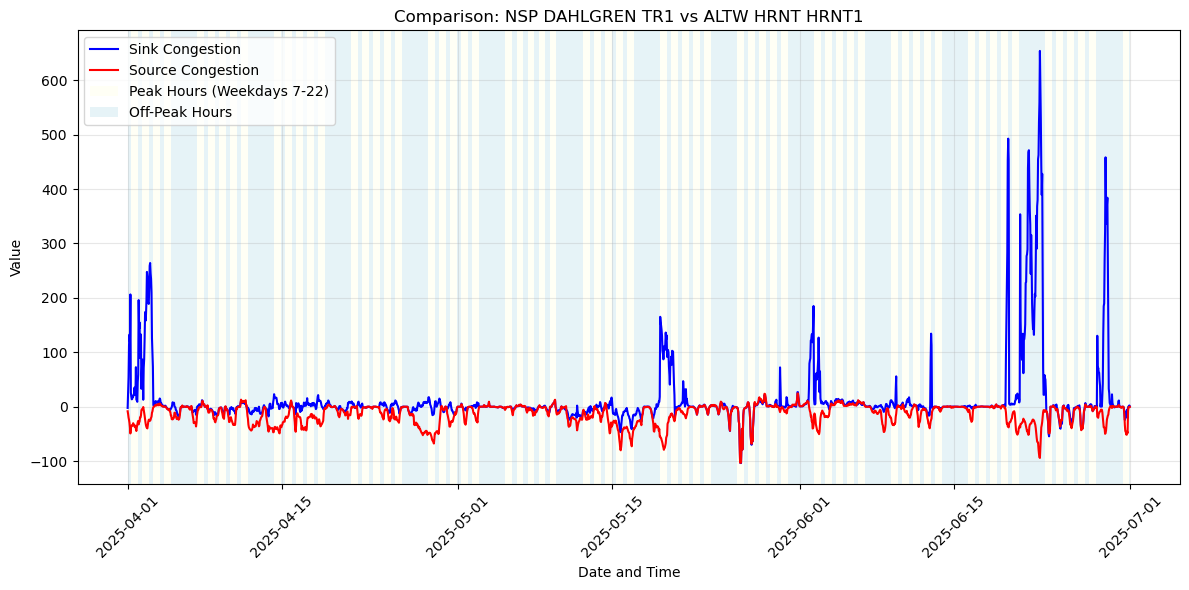

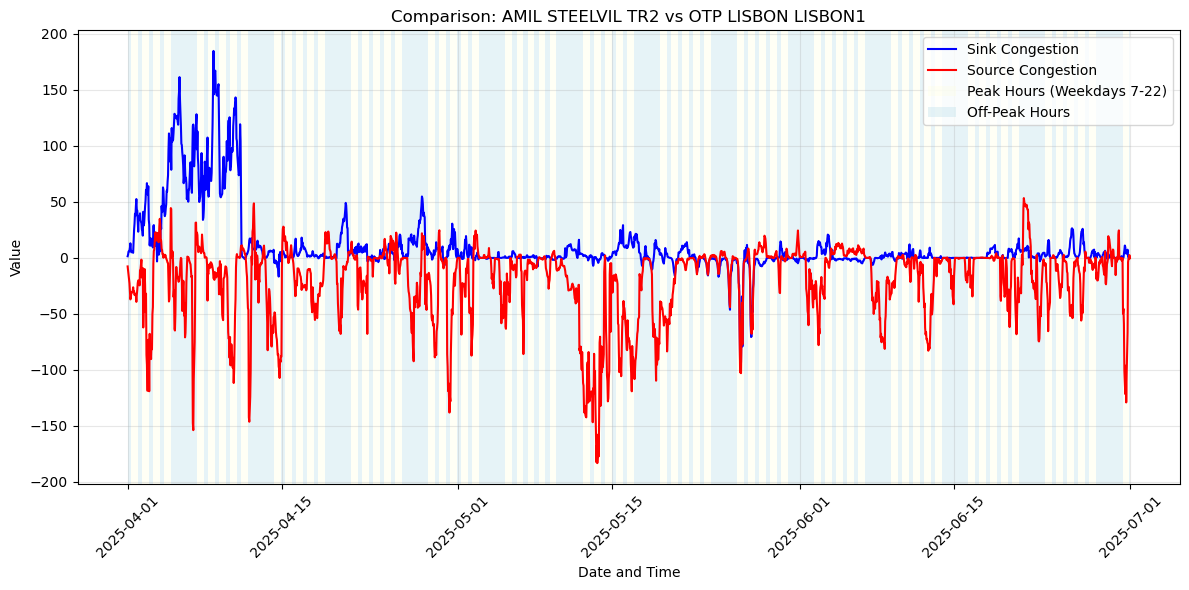

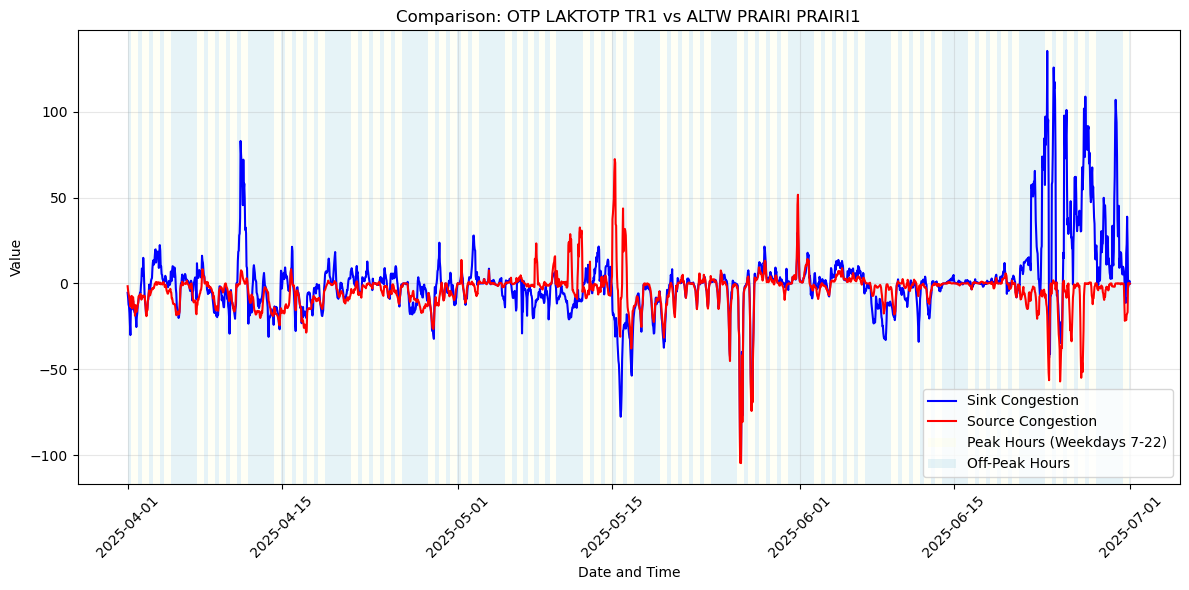

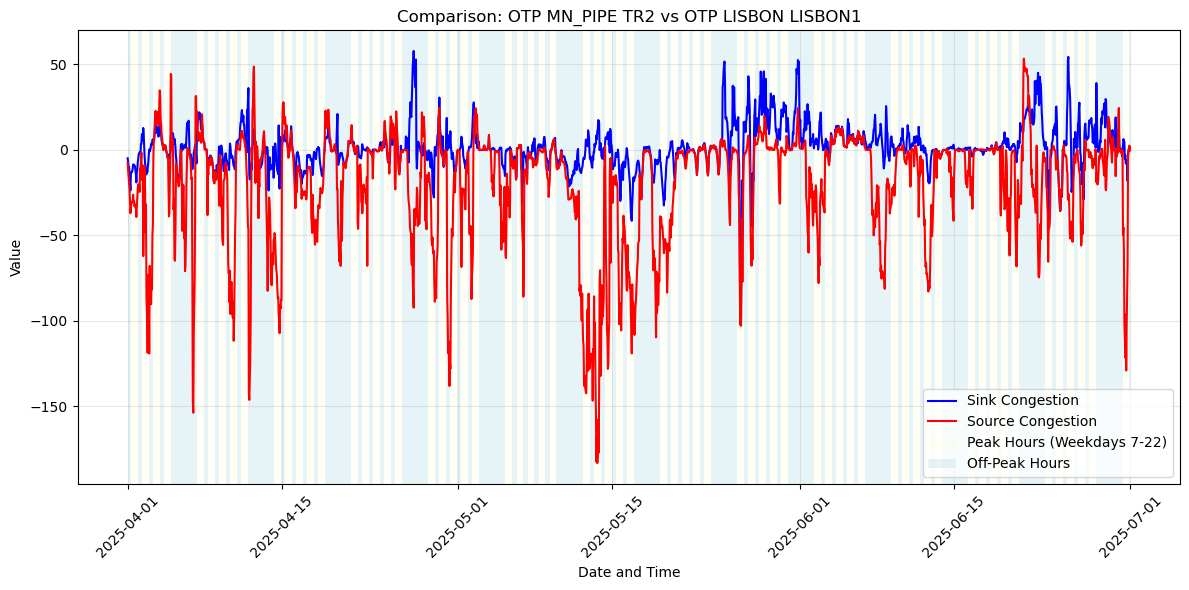

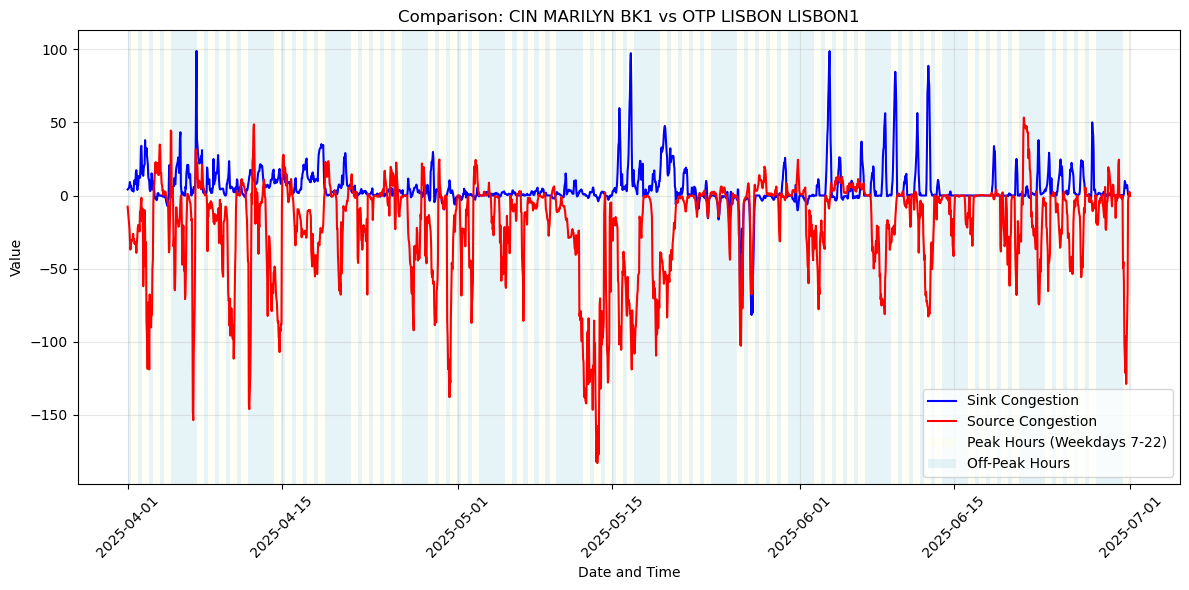

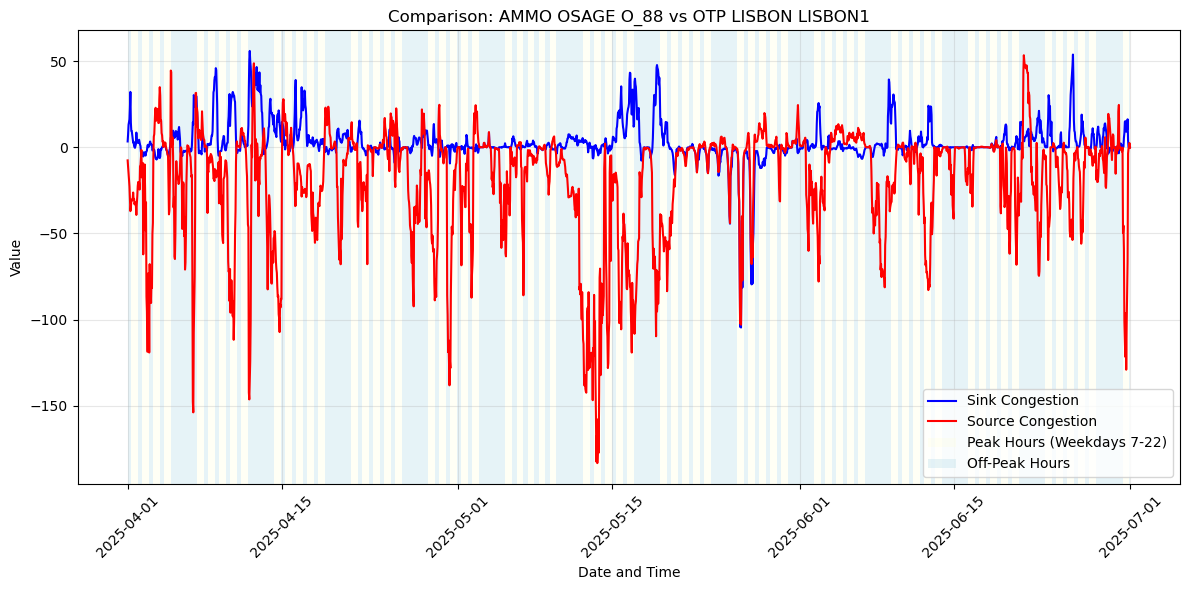

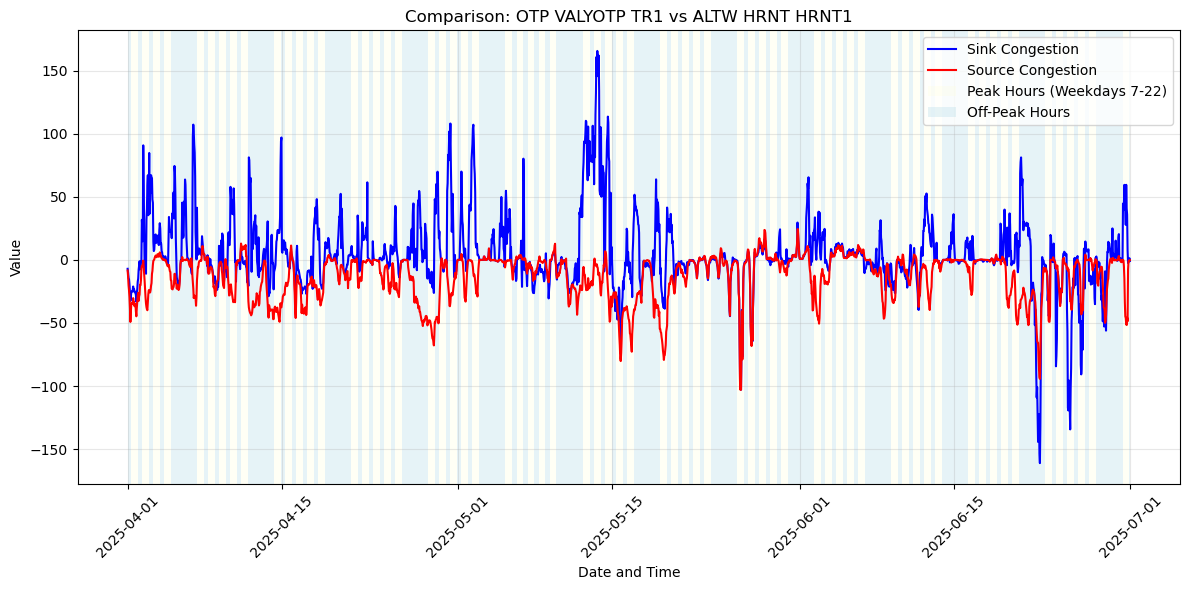

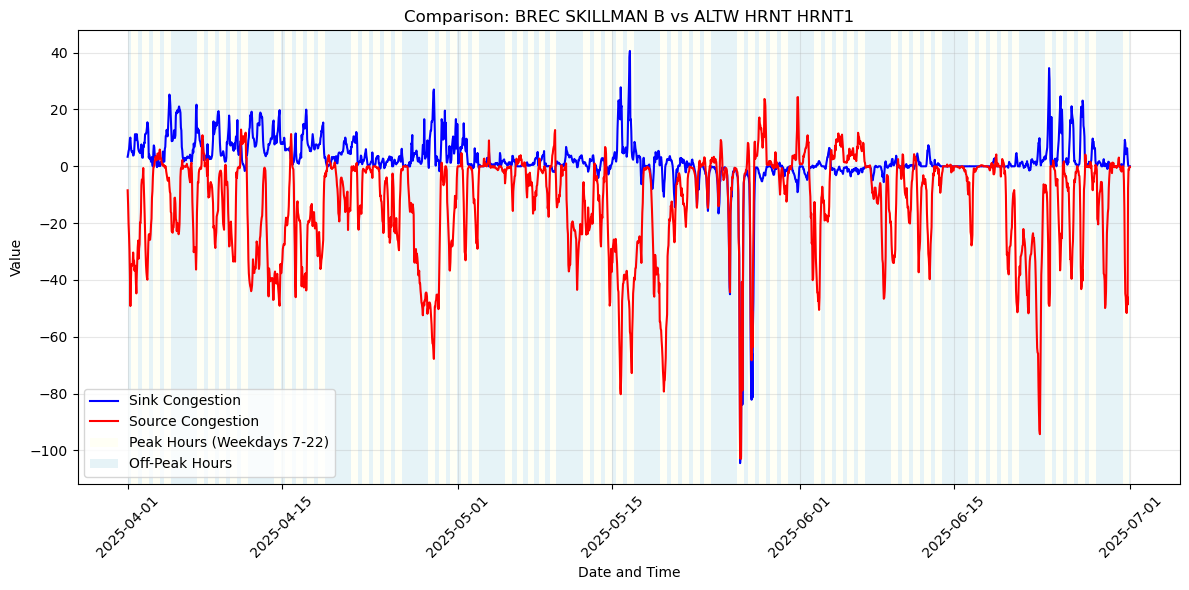

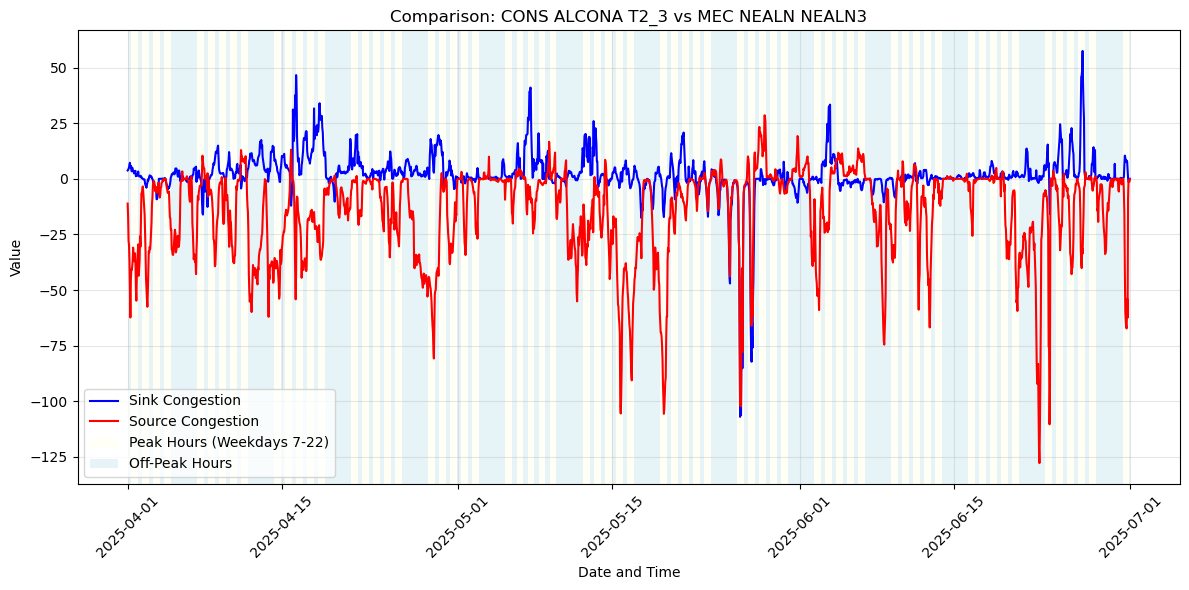

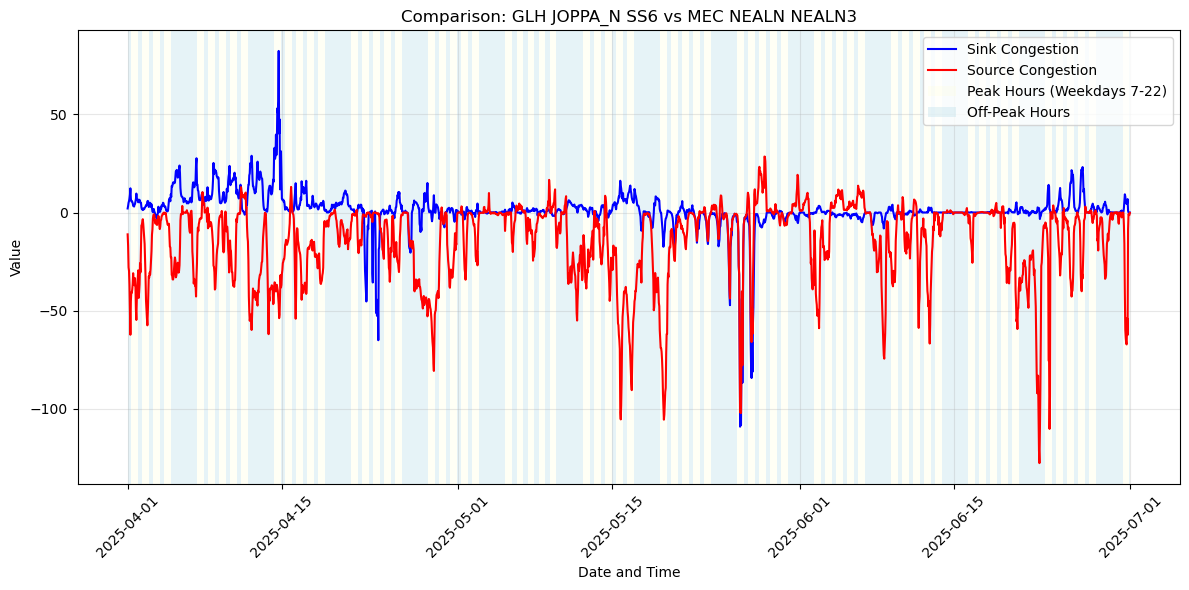

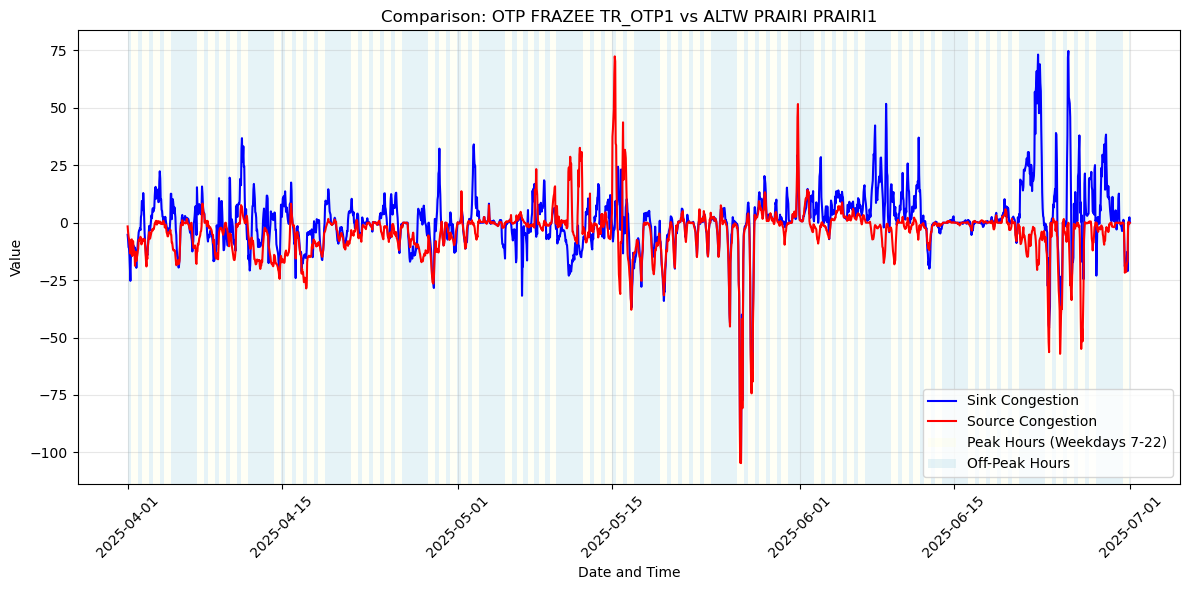

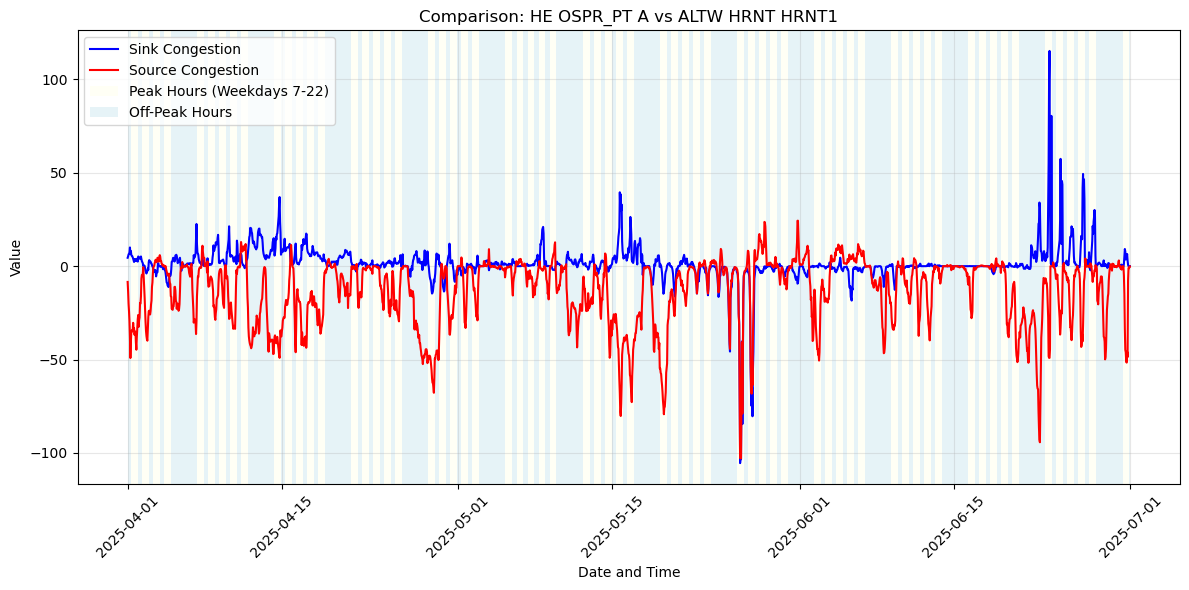

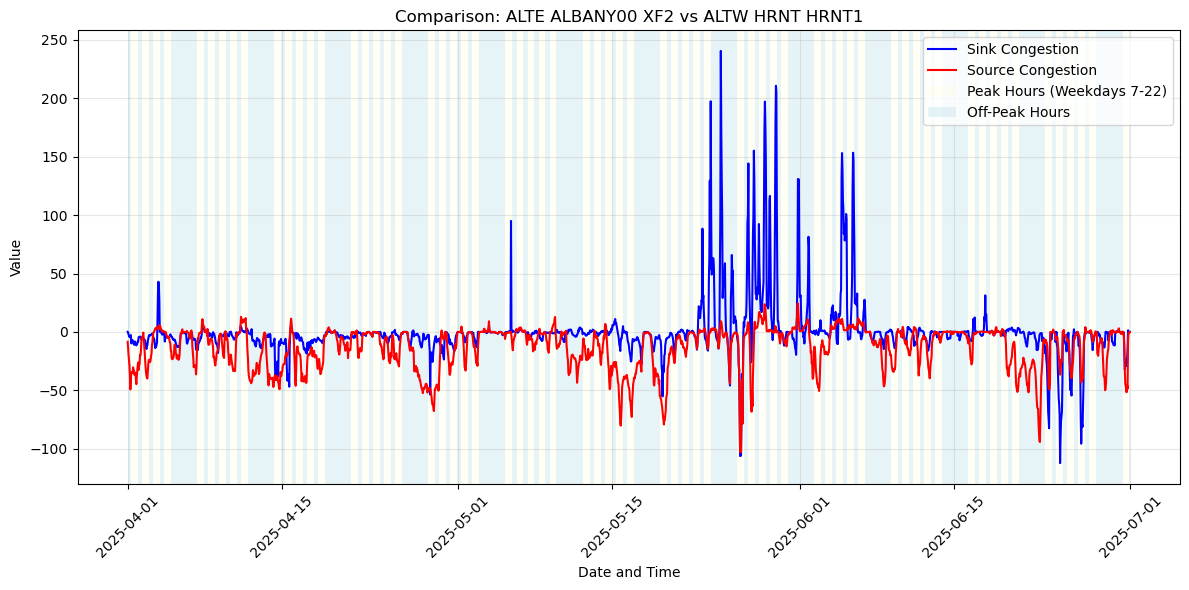

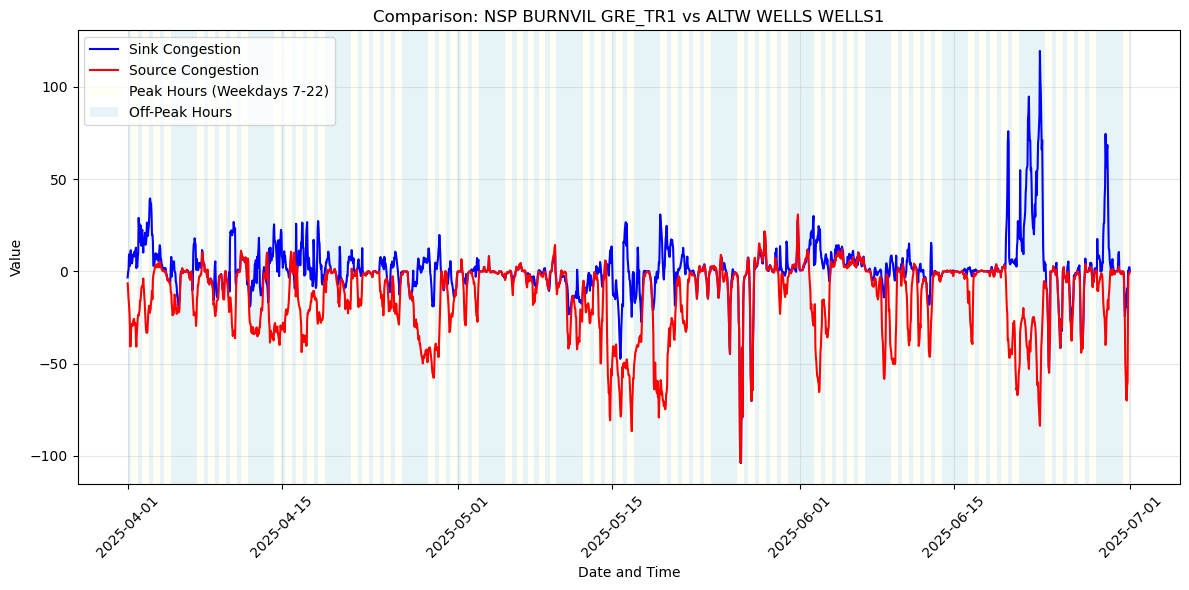

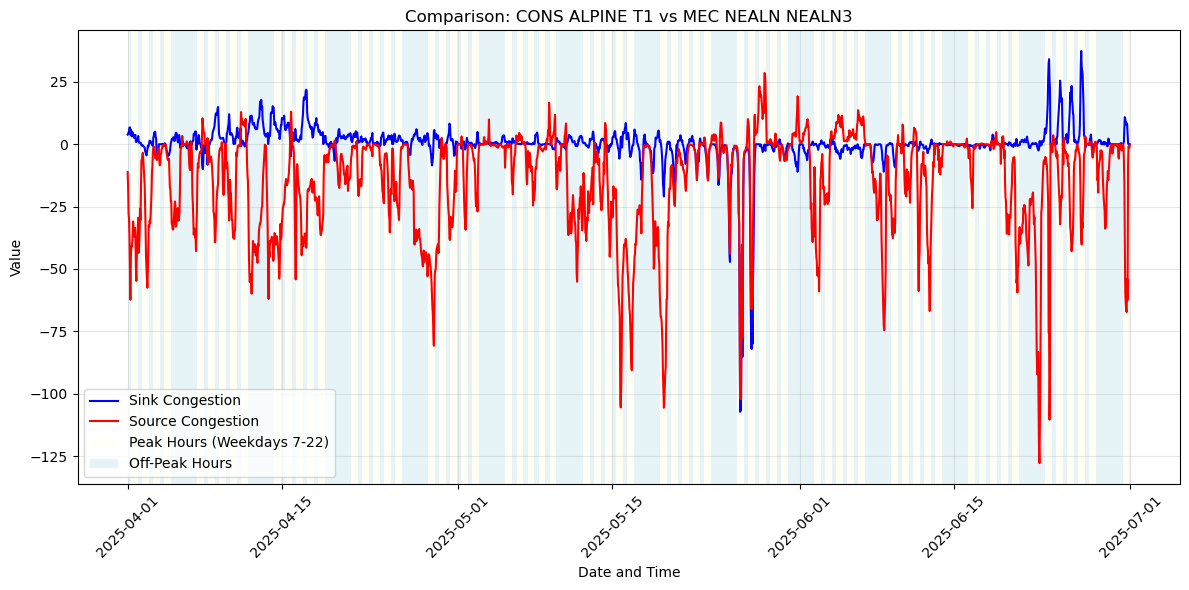

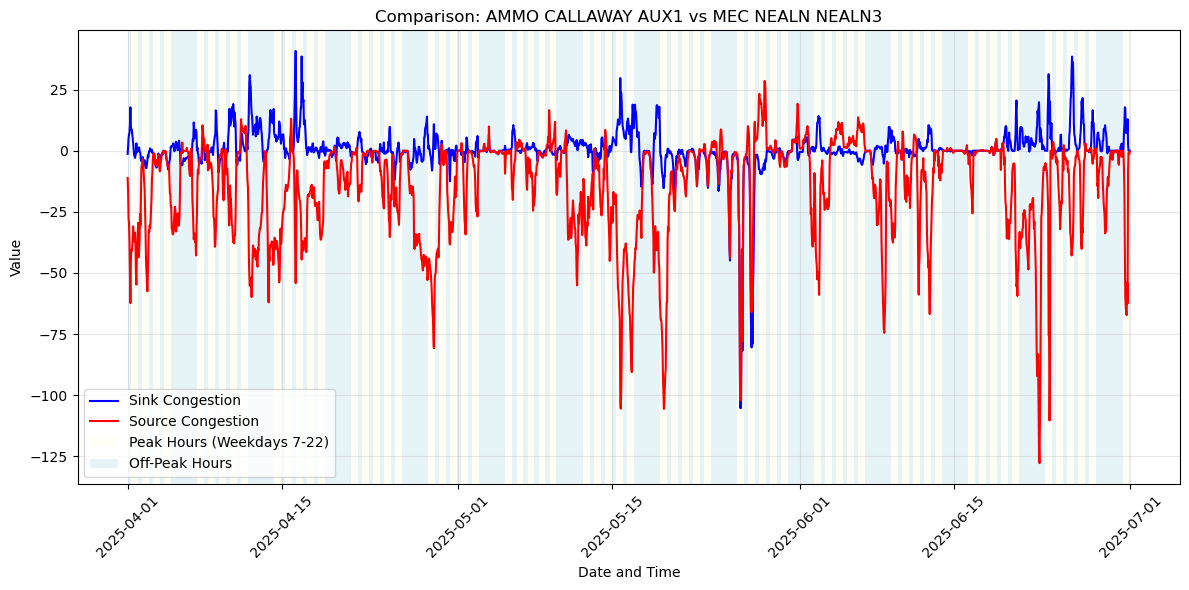

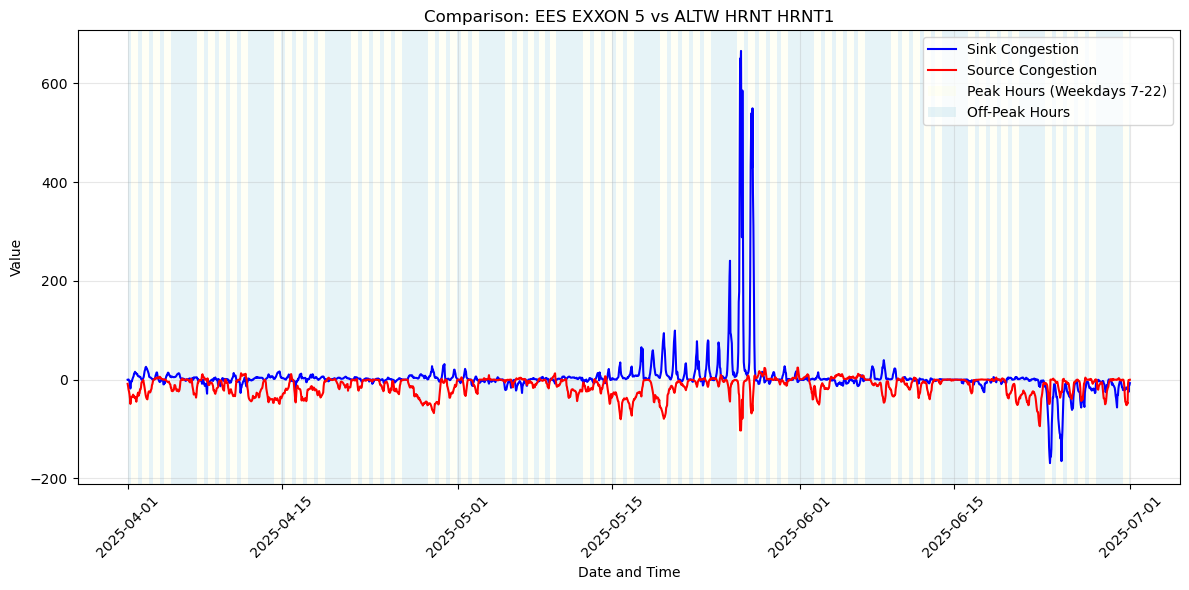

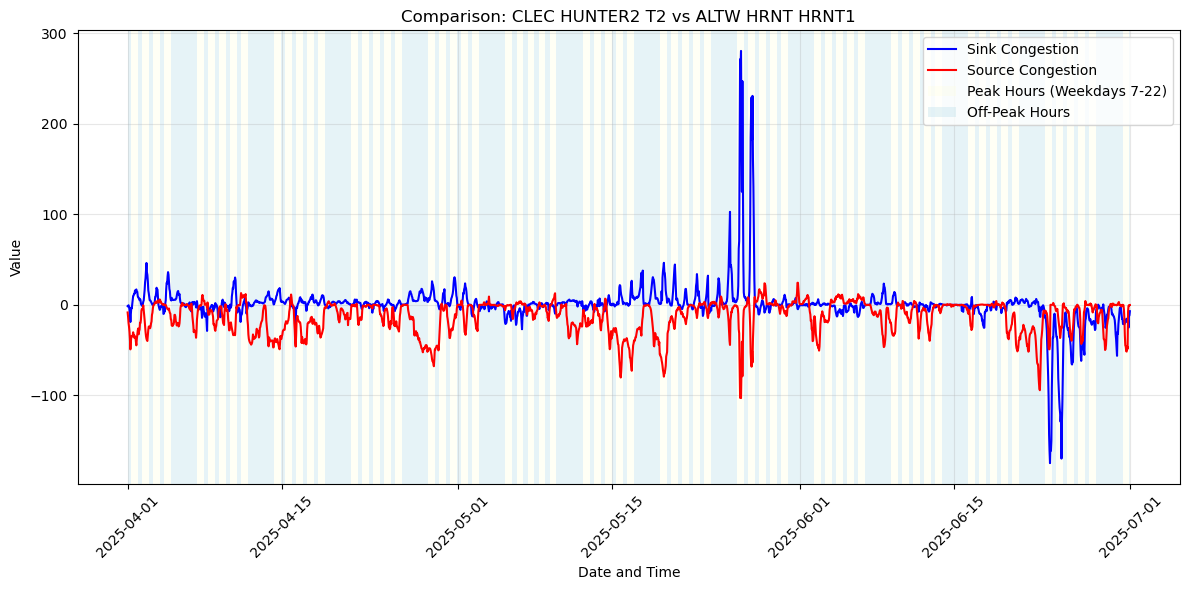

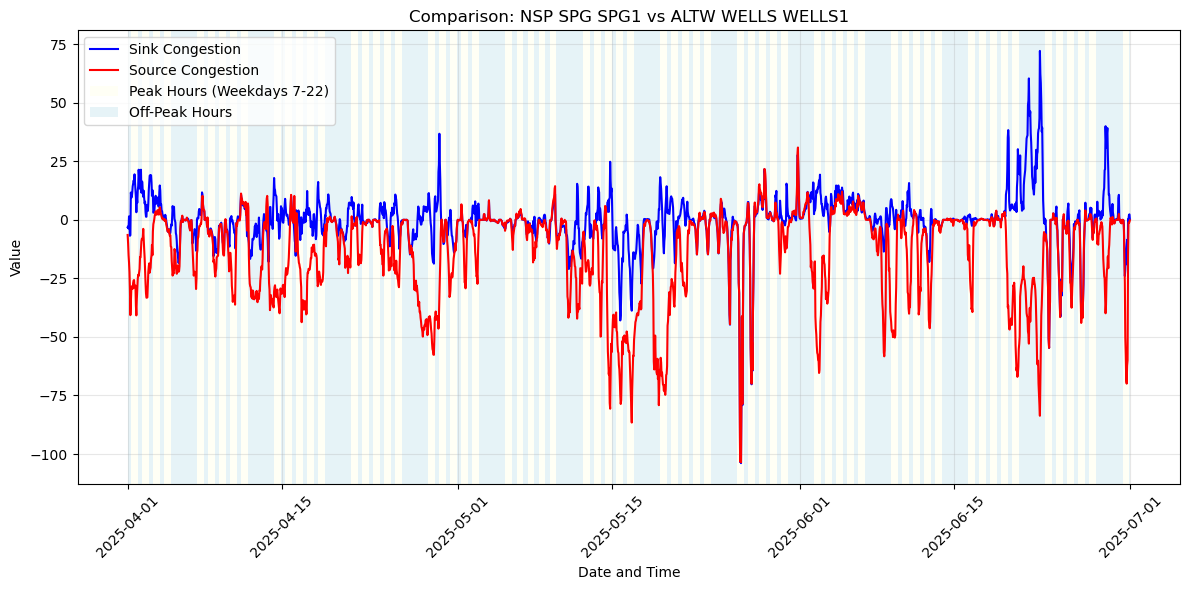

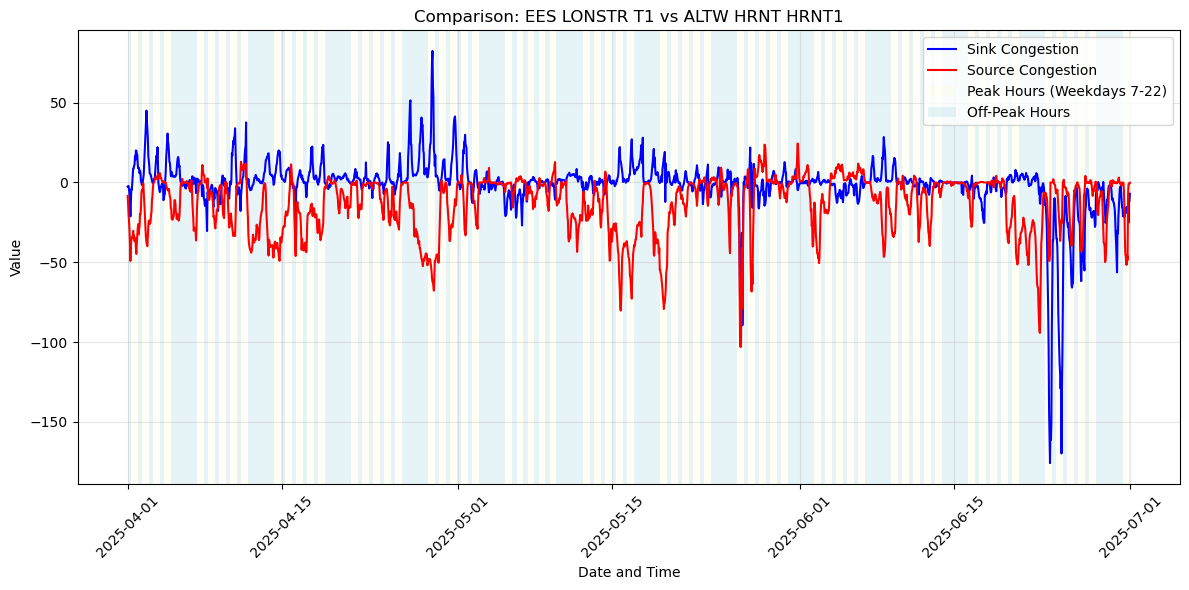

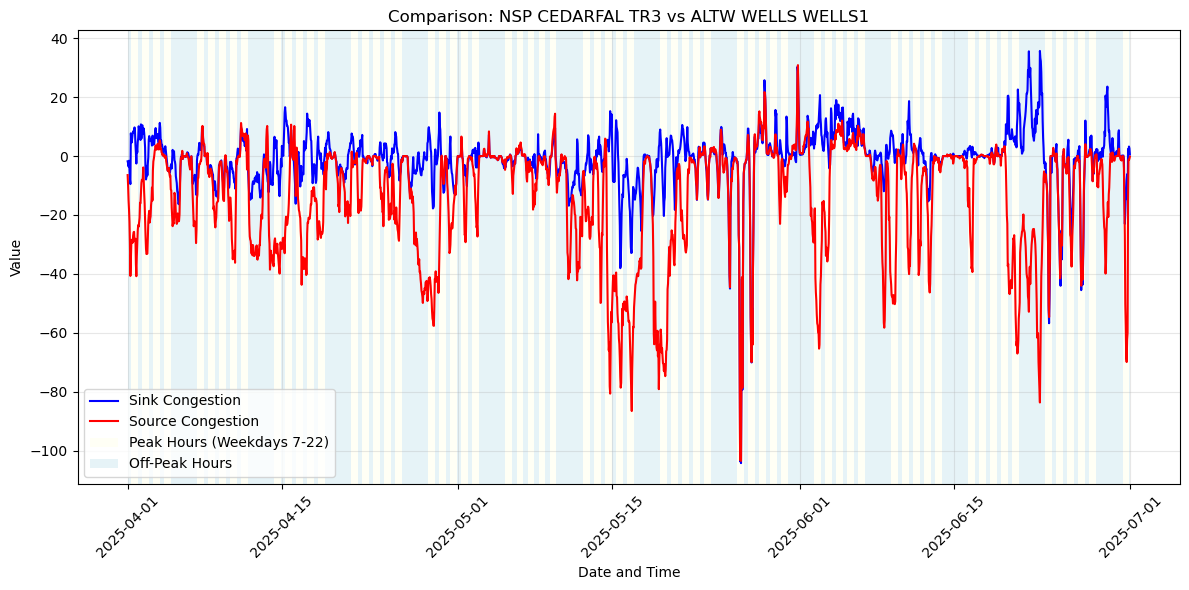

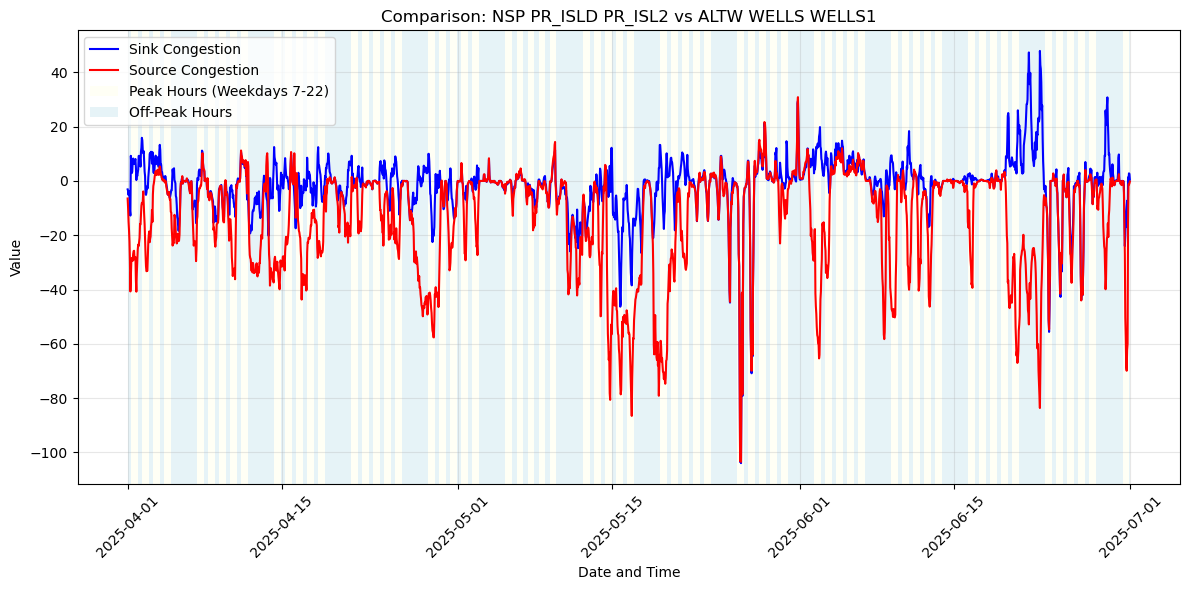

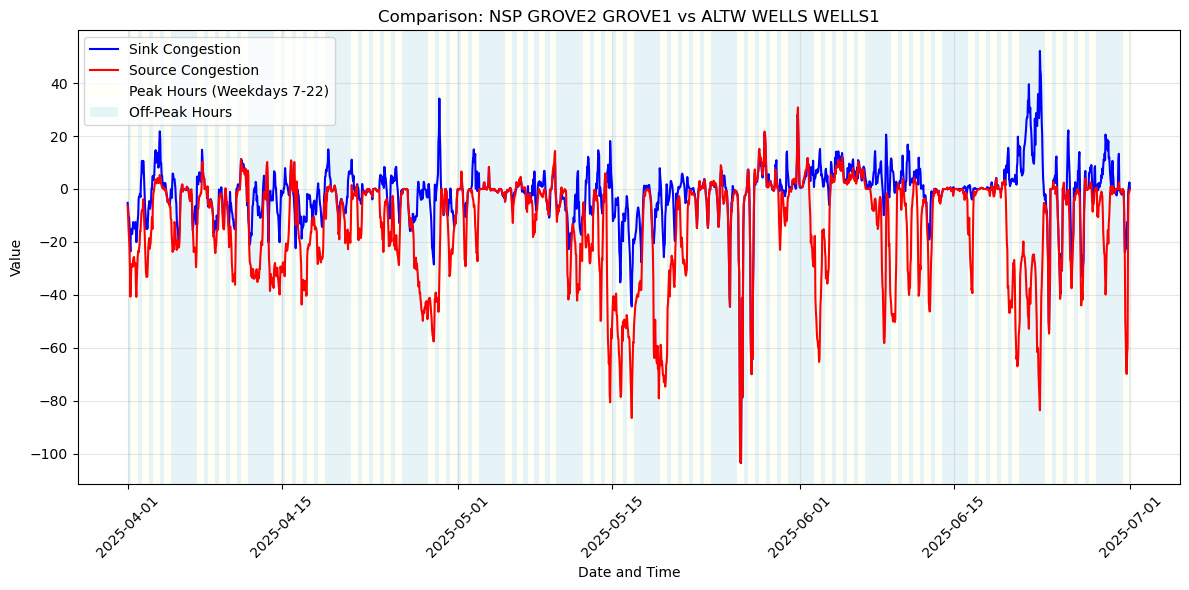

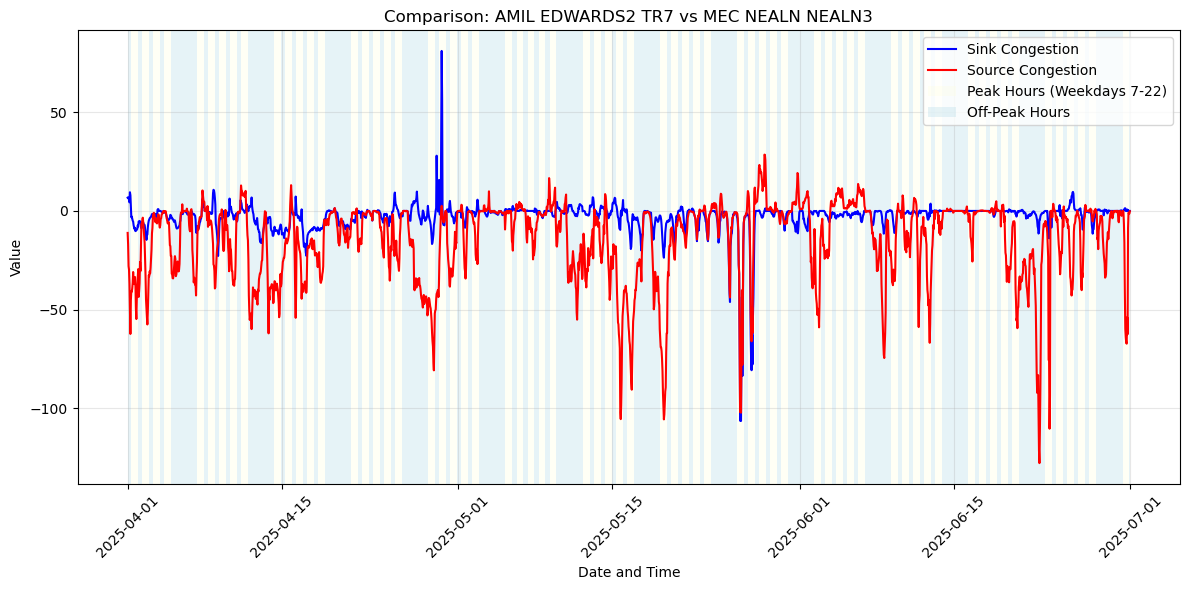

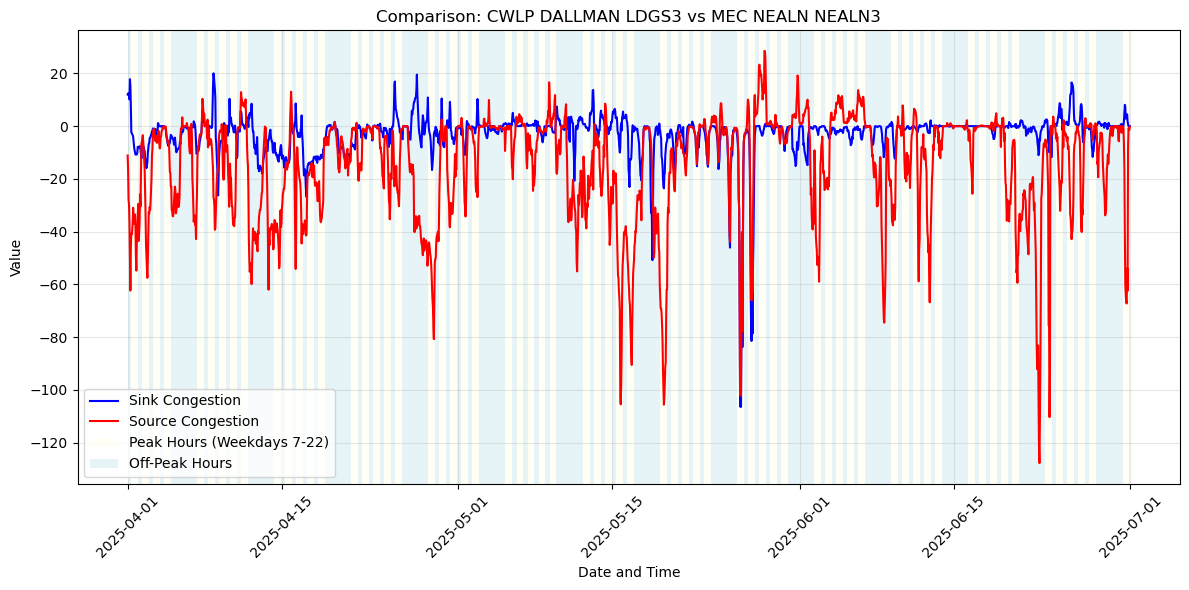

In [69]:
# Open a multi-page PDF
with PdfPages('Outputs/offPeak_LMP_timeseries.pdf') as pdf:
    for i in range(len(best_sink_source_spreads)):
        # Determine best cluster and node
        cluster = offPeakCombined.loc[offPeakCombined['node'] == best_sink_source_spreads.loc[i, 'source'], 'cluster'].item()
        
        node = top_source_matches.loc[top_source_matches['cluster'] == cluster, 'node'].item()
        
        # Update source in best spread list
        best_sink_source_spreads.loc[i, 'source'] = node

        # Get DA LMP data
        DA_LMP_train_InterestNodeSource = DA_LMP_train.loc[DA_LMP_train['node'] == node]
        DA_LMP_train_InterestNodeSink = DA_LMP_train.loc[DA_LMP_train['node'] == best_sink_source_spreads.loc[i, 'sink']]

        # Plot using your function and save the figure
        fig, ax = plot_dual_timeseries(
            DA_LMP_train_InterestNodeSink,
            DA_LMP_train_InterestNodeSource,
            y_column1='congestion',
            label1='Sink Congestion',
            label2='Source Congestion'
        )
        
        pdf.savefig(fig)
        plt.close(fig)  # Close to avoid displaying or memory issues

In [70]:
strategy_results = pd.DataFrame(columns = ['Analysis Start Date', 'Analysis End Date', 'Mean Congestion Spread', 'Congestion Spread Standard Dev', 'LMP Sink', 'Closest matching FTR Sink', 'LMP Source', 'Closest matching FTR Source'])

## Off Peak strategy results ##
for i in range(0, len(best_sink_source_spreads)): 
    # off peak sink node assignment
    off_peak_DA_LMP_train_InterestNodeSink = off_peak_DA_LMP_train.loc[off_peak_DA_LMP_train['node'] == best_sink_source_spreads.loc[i, 'sink'], :]
    off_peak_DA_LMP_train_InterestNodeSink = off_peak_DA_LMP_train_InterestNodeSink.set_index(pd.to_datetime(off_peak_DA_LMP_train_InterestNodeSink['datetime']))
    
    #source node assignment
    off_peak_DA_LMP_train_InterestNodeSource = off_peak_DA_LMP_train.loc[off_peak_DA_LMP_train['node'] == best_sink_source_spreads.loc[i, 'source'], :]
    off_peak_DA_LMP_train_InterestNodeSource = off_peak_DA_LMP_train_InterestNodeSource.set_index(pd.to_datetime(off_peak_DA_LMP_train_InterestNodeSource['datetime']))
    
    #analyze on peak difference for on peak strategy
    CongestionSpread_TimeSeries = off_peak_DA_LMP_train_InterestNodeSink.loc[:, 'congestion'] - off_peak_DA_LMP_train_InterestNodeSource.loc[:, 'congestion']
    
    # Creating a dataframe that holds strategy relevant information
    strategy_results.loc[i, 'Analysis Start Date'] = CongestionSpread_TimeSeries.index.min()
    strategy_results.loc[i, 'Analysis End Date'] = CongestionSpread_TimeSeries.index.max()
    strategy_results.loc[i, 'Mean Congestion Spread'] = round(CongestionSpread_TimeSeries.mean(), 2)
    strategy_results.loc[i, 'Congestion Spread Standard Dev'] = round(CongestionSpread_TimeSeries.std(), 2)
    strategy_results.loc[i, 'LMP Sink'] = best_sink_source_spreads.loc[i, 'sink']
    strategy_results.loc[i, 'Closest matching FTR Sink'] = offPeakCombined.loc[offPeakCombined['node'] == best_sink_source_spreads.loc[i, 'sink'], 'matched_source_sink'].item()
    strategy_results.loc[i, 'LMP Source'] = best_sink_source_spreads.loc[i, 'source']
    strategy_results.loc[i, 'Closest matching FTR Source'] = offPeakCombined.loc[offPeakCombined['node'] == best_sink_source_spreads.loc[i, 'source'], 'matched_source_sink'].item()
    
    print(f"OFF PEAK STRATEGY for sink {best_sink_source_spreads.loc[i, 'sink']} and source {best_sink_source_spreads.loc[i, 'source']}:")
    print(f"Congestion spread expected value: ${round(CongestionSpread_TimeSeries.mean(), 2)}")
    print(f"Congestion spread standard deviation: ${round(CongestionSpread_TimeSeries.std(), 2)}")
    MW_Bid = 1
    Hourly_profit = CongestionSpread_TimeSeries.mean() * MW_Bid
    Monthly_profit = Hourly_profit * 720
    print(f"Monthly value of 1 MW: ${round(Monthly_profit, 2)}")
    print('---------------------------')

strategy_results.to_csv('Outputs/OffPeakStrategyResults.csv')


OFF PEAK STRATEGY for sink NSP DAHLGREN TR1 and source ALTW HRNT HRNT1:
Congestion spread expected value: $32.57
Congestion spread standard deviation: $86.66
Monthly value of 1 MW: $23452.79
---------------------------
OFF PEAK STRATEGY for sink AMIL STEELVIL TR2 and source OTP LISBON LISBON1:
Congestion spread expected value: $29.45
Congestion spread standard deviation: $43.65
Monthly value of 1 MW: $21205.32
---------------------------
OFF PEAK STRATEGY for sink OTP LAKTOTP TR1 and source ALTW PRAIRI PRAIRI1:
Congestion spread expected value: $4.24
Congestion spread standard deviation: $21.28
Monthly value of 1 MW: $3056.19
---------------------------
OFF PEAK STRATEGY for sink OTP MN_PIPE TR2 and source OTP LISBON LISBON1:
Congestion spread expected value: $20.8
Congestion spread standard deviation: $30.38
Monthly value of 1 MW: $14975.9
---------------------------
OFF PEAK STRATEGY for sink CIN MARILYN BK1 and source OTP LISBON LISBON1:
Congestion spread expected value: $21.67
Cong